#Connect to G-Drive

In [ ]:
# Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting the file path that contains the dataset
import os
os.chdir("/content/drive/MyDrive/Data Science Project/Banking Dataset - Marketing Targets/dataset")

In [ ]:
# Showing all data in the file path from os.chdir(...)
!ls

banking_targeting_preprocessed.csv  shap_force_plot.html
catboost_info			    shap_summary_bar.png
confusion_matrix.png		    shap_summary_dot.png
model_selection_results.csv	    test.csv
precision_recall_curve.png	    train.csv
roc_curve.png


# Import Dependencies

In [ ]:
!pip install optuna

In [ ]:
pip install catboost

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

#Analysis
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
from imblearn.combine import SMOTETomek
from scipy.stats import boxcox
from sklearn.preprocessing import (
    RobustScaler, StandardScaler,
    PowerTransformer
)

#Machine Learning Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


#Model Tuning
import optuna
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    GridSearchCV
)

#Evaluation
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
    average_precision_score,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    auc,
    precision_score,
    accuracy_score,
    recall_score,
    make_scorer,
    f1_score
)

#Model Interpretation
import shap

#Saving Model
import pickle

#Load Dataset

In [ ]:
# Creating dataframe from csv
df = pd.read_csv("train.csv", sep= ";", index_col= False)

In [ ]:
# 10 data's from top 5 and bottom 5
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


#Context

Term deposits are a major source of income for a bank. A term deposit is a cash investment held at a financial institution. Your money is invested for an agreed rate of interest over a fixed amount of time, or term. The bank has various outreach plans to sell term deposits to their customers such as email marketing, advertisements, telephonic marketing, and digital marketing.

Telephonic marketing campaigns still remain one of the most effective way to reach out to people. However, they require huge investment as large call centers are hired to actually execute these campaigns. Hence, it is crucial to identify the customers most likely to convert beforehand so that they can be specifically targeted via call.

The data is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe to a term deposit (variable y).


The data is related to the direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed by the customer or not. The data folder contains two datasets:

*   **train.csv**: 45,211 rows and 18 columns ordered by date (from May 2008 to November 2010)
*   **test.csv**: 4521 rows and 18 columns with 10% of the examples (4521), randomly selected from train.csv

**Disclaimer**: In this project, I **ONLY** use train.csv to **avoid** data leakage during model testing karena isi dari test.csv merupakan 10% dari train.csv.


**Detailed Column Descriptions**

*   **age** : (numeric)
*   **job** : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")
*   **marital** : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
*   **education** (categorical: "unknown","secondary","primary","tertiary")
*   default: has credit in default? (binary: "yes","no")
*   **balance**: average yearly balance, in euros (numeric)
*   **housing**: has housing loan? (binary: "yes","no")
*   **loan**: has personal loan? (binary: "yes","no")
*   **contact**: contact communication type (categorical: "unknown","telephone","cellular")
*   **day**: last contact day of the month (numeric)
*   **month**: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")
*   **duration**: last contact duration, in seconds (numeric)
*   **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact)
*   **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
*   **previous**: number of contacts performed before this campaign and for this client (numeric)
*   **poutcome**: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")
*   **y** - has the client subscribed a term deposit? (binary: "yes","no")

**Citation**

S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

**Acknowledgement**

Created by: Paulo Cortez (Univ. Minho) and Sérgio Moro (ISCTE-IUL) @ 2012. Thanks to Berkin Kaplanoğlu for helping with the proper column descriptions.

kaggle:
https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets


**Business Problem Statement**

The goal is to build a classification model that predicts whether a client will subscribe to a term deposit ('y') using campaign related variables. A well performing model will help reduce telemarketing costs by improving targeting efficiency.

# Summary

# 1.&nbsp; Exploratory Data Analysis

## 1.1.&nbsp; Data Understanding

This section aims to provide a brief understanding of the data so that you know what needs to be done and to ease further analysis.

In [ ]:
# 10 data's from top 5 and bottom 5
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [ ]:
# Summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [ ]:
df.shape

(45211, 17)

The **`duration`** column shows how long customers have been connected to customer service, while new customers have never been connected to customer service.
This column was removed because it caused feature leakage.


In [ ]:
df.drop(columns= 'duration', inplace= True)

In [ ]:
df.shape

(45211, 16)

In [ ]:
print(df['y'].value_counts(), '\n')
print(df['y'].value_counts(normalize=True) * 100)

y
no     39922
yes     5289
Name: count, dtype: int64 

y
no     88.30152
yes    11.69848
Name: proportion, dtype: float64


In [ ]:
# Descriptive statistic of numeric data
df.describe(
    percentiles= [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99],
).T

,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
age,45211.0,40.936210,10.618762,18.0,23.0,29.0,33.0,39.0,48.0,56.0,71.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,-627.0,0.0,72.0,448.0,1428.0,3574.0,13164.9,102127.0
day,45211.0,15.806419,8.322476,1.0,2.0,5.0,8.0,16.0,21.0,28.0,31.0,31.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,1.0,1.0,2.0,3.0,5.0,16.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,185.0,370.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,0.0,0.0,2.0,8.9,275.0


In [ ]:
# Descriptive statistic of categorical data
df.describe(
    include= 'object',
).T

,count,unique,top,freq
job,45211,12,blue-collar,9732
marital,45211,3,married,27214
education,45211,4,secondary,23202
default,45211,2,no,44396
housing,45211,2,yes,25130
loan,45211,2,no,37967
contact,45211,3,cellular,29285
month,45211,12,may,13766
poutcome,45211,4,unknown,36959
y,45211,2,no,39922


In [ ]:
df.duplicated().sum()

np.int64(16)

In [ ]:
# Showing data duplicates
df[df.duplicated()]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
2871,44,services,single,secondary,no,0,yes,no,unknown,14,may,1,-1,0,unknown,no
4910,34,management,single,tertiary,no,0,yes,no,unknown,21,may,1,-1,0,unknown,no
12939,25,blue-collar,married,primary,no,0,no,no,cellular,7,jul,1,-1,0,unknown,no
13662,47,services,married,secondary,no,0,yes,no,cellular,9,jul,1,-1,0,unknown,no
15836,35,management,married,tertiary,no,0,yes,no,cellular,21,jul,3,-1,0,unknown,no
21522,47,technician,married,secondary,no,0,no,no,cellular,19,aug,2,-1,0,unknown,no
22157,31,management,single,tertiary,no,0,no,no,cellular,21,aug,2,-1,0,unknown,no
22210,32,technician,single,tertiary,no,0,no,no,cellular,21,aug,2,-1,0,unknown,no
22233,34,management,single,tertiary,no,0,no,no,cellular,21,aug,2,-1,0,unknown,no
22418,30,technician,single,tertiary,no,0,no,no,cellular,22,aug,2,-1,0,unknown,no


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.shape

(45195, 16)

## 1.2.&nbsp; Identifying Missing Value

In [ ]:
# Summary of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45195 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45195 non-null  int64 
 1   job        45195 non-null  object
 2   marital    45195 non-null  object
 3   education  45195 non-null  object
 4   default    45195 non-null  object
 5   balance    45195 non-null  int64 
 6   housing    45195 non-null  object
 7   loan       45195 non-null  object
 8   contact    45195 non-null  object
 9   day        45195 non-null  int64 
 10  month      45195 non-null  object
 11  campaign   45195 non-null  int64 
 12  pdays      45195 non-null  int64 
 13  previous   45195 non-null  int64 
 14  poutcome   45195 non-null  object
 15  y          45195 non-null  object
dtypes: int64(6), object(10)
memory usage: 5.9+ MB


In [ ]:
# Sum of Null from each column
df.isna().sum()

,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


Since there are no missing values, there is no need to handle them.

## 1.3.&nbsp; Identifying Outlier

In [ ]:
# Categorize the columns into numerical and categorical columns
num_cols = []
cat_cols = []

for col in df.columns:
  if df[col].dtypes == "object":
    cat_cols.append(col)
  else:
    num_cols.append(col)

The data is separated based on type because the method for finding outliers differs for numerical and categorical data.

In [ ]:
# Showing each column
print("Numerical columns:", num_cols)
print("Categorical columns:", cat_cols)

Numerical columns: ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']


### 1.3.1.&nbsp; Identifying Outlier in Numerical

In [ ]:
# Checking outliers using IQR methods
def outlier_thresholds(
    df, feature,
    quantile_lower= 0.25,
    quantile_upper= 0.75):

  Q1 = df[feature].quantile(quantile_lower)
  Q3 = df[feature].quantile(quantile_upper)
  IQR = Q3 - Q1

  lower_limit = Q1 - 1.5 * IQR
  upper_limit = Q3 + 1.5 * IQR

  return lower_limit, upper_limit

def has_outliers(
    df, feature,
    quantile_lower= 0.25,
    quantile_upper= 0.75):

  low_lim, up_lim = outlier_thresholds(df, feature, quantile_lower, quantile_upper)

  exist_lower_outliers = (df[feature] < low_lim).any(axis=None)
  exist_upper_outliers = (df[feature] > up_lim).any(axis=None)

  return (exist_lower_outliers or exist_upper_outliers)

In [ ]:
def outlier_percentage(df, feature, quantile_lower=0.25, quantile_upper=0.75):
    low_lim, up_lim = outlier_thresholds(df, feature, quantile_lower, quantile_upper)

    num_outliers = ((df[feature] < low_lim) | (df[feature] > up_lim)).sum()
    total_values = len(df[feature])

    percentage = (num_outliers / total_values) * 100
    return percentage

In [ ]:
feats_with_outliers = []

for feat in num_cols:
    exist_outliers = has_outliers(df, feat)
    if exist_outliers:
        perc_outliers = outlier_percentage(df, feat)
        print(f"Outliers exist in {feat}! ({perc_outliers:.2f}% of data)")
        feats_with_outliers.append(feat)
    else:
        print(f"There are no outliers in {feat}.")

Outliers exist in age! (1.08% of data)
Outliers exist in balance! (10.46% of data)
There are no outliers in day.
Outliers exist in campaign! (6.78% of data)
Outliers exist in pdays! (18.27% of data)
Outliers exist in previous! (18.27% of data)


### 1.3.2.&nbsp; Identifying Outlier in Categorical

In [ ]:
for col in cat_cols:
  val_dist = df[col].unique()
  num_dist = df[col].nunique()

  print(f"{col}: {num_dist} ==>> {val_dist} \n")

job: 12 ==>> ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student'] 

marital: 3 ==>> ['married' 'single' 'divorced'] 

education: 4 ==>> ['tertiary' 'secondary' 'unknown' 'primary'] 

default: 2 ==>> ['no' 'yes'] 

housing: 2 ==>> ['yes' 'no'] 

loan: 2 ==>> ['no' 'yes'] 

contact: 3 ==>> ['unknown' 'cellular' 'telephone'] 

month: 12 ==>> ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep'] 

poutcome: 4 ==>> ['unknown' 'failure' 'other' 'success'] 

y: 2 ==>> ['no' 'yes'] 



In [ ]:
for col in cat_cols:
    print(f"=== {col} ===")
    print(df[col].value_counts(normalize= True))
    print()

=== job ===
job
blue-collar      0.215289
management       0.209116
technician       0.168005
admin.           0.114415
services         0.091869
retired          0.050072
self-employed    0.034937
entrepreneur     0.032902
unemployed       0.028831
housemaid        0.027437
student          0.020755
unknown          0.006372
Name: proportion, dtype: float64

=== marital ===
marital
married     0.602013
single      0.282775
divorced    0.115212
Name: proportion, dtype: float64

=== education ===
education
secondary    0.513309
tertiary     0.294081
primary      0.151521
unknown      0.041089
Name: proportion, dtype: float64

=== default ===
default
no     0.981967
yes    0.018033
Name: proportion, dtype: float64

=== housing ===
housing
yes    0.555946
no     0.444054
Name: proportion, dtype: float64

=== loan ===
loan
no     0.839717
yes    0.160283
Name: proportion, dtype: float64

=== contact ===
contact
cellular     0.647660
unknown      0.288041
telephone    0.064299
Name: proport

Several categories exhibit very small or very large proportions that could be considered statistical outliers. However, they were retained for the following reasons:

*   Analytical relevance – even small proportions can hold important insights, such as December (0.47%), which is critical for identifying seasonal patterns.
*   Distinct semantic meaning – categories like “yes” and “no” in the default variable are inherently different and cannot be logically merged, even if one has a low frequency (e.g., 1.8%).
*   Domain knowledge considerations – small categories are preserved if they have significant business meaning, while “unknown” is reserved for categories that are genuinely unclear or extremely rare without specific analytical value.

Because of these reasons, outliers in categorical are retained.

## 1.4.&nbsp; Data Visualization

### 1.4.1.&nbsp; Data Distribution



In [ ]:
df[num_cols].skew().sort_values(ascending=False)

,0
previous,41.840198
balance,8.359274
campaign,4.898646
pdays,2.615075
age,0.684684
day,0.093451


Some columns have very high positive skew values. This means that the data distribution in those columns is heavily skewed to the right. A transformation will be performed on those columns.

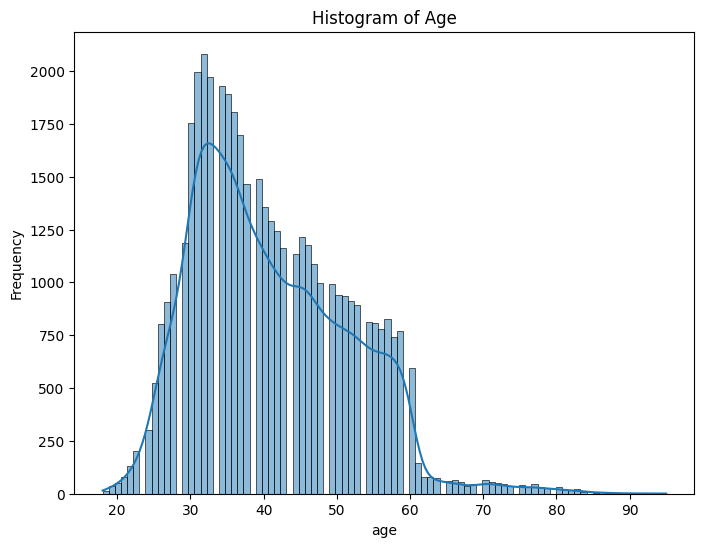

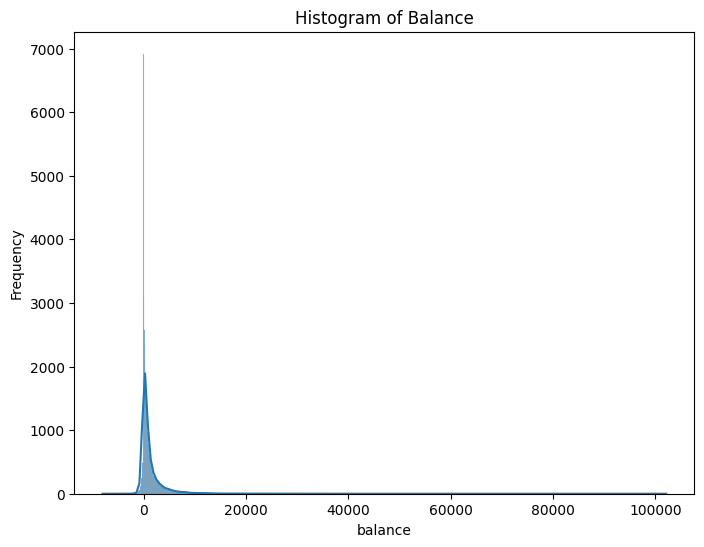

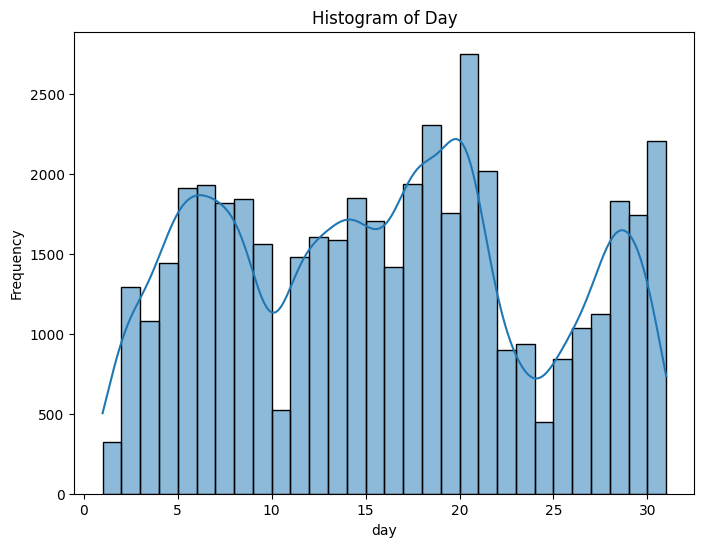

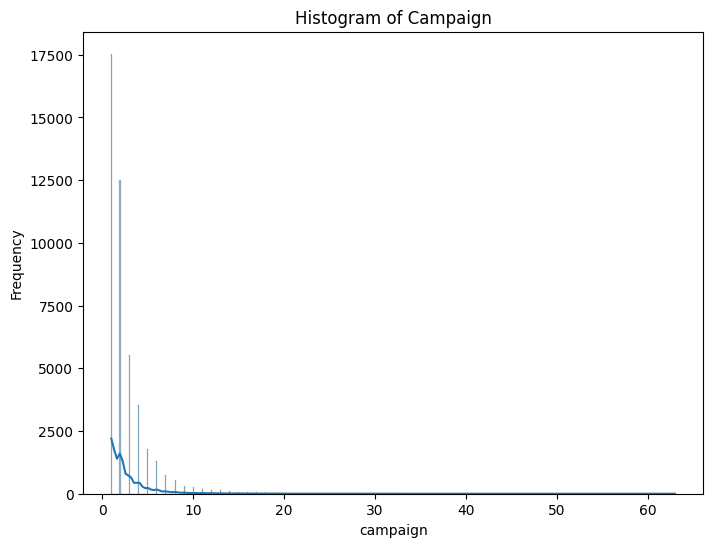

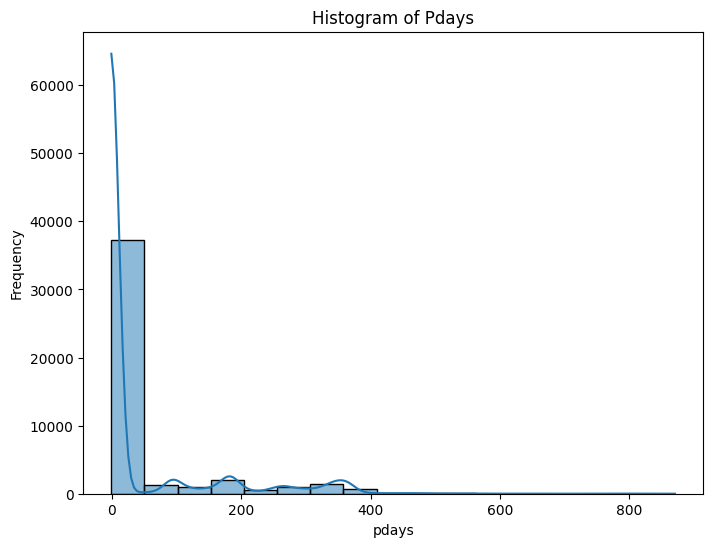

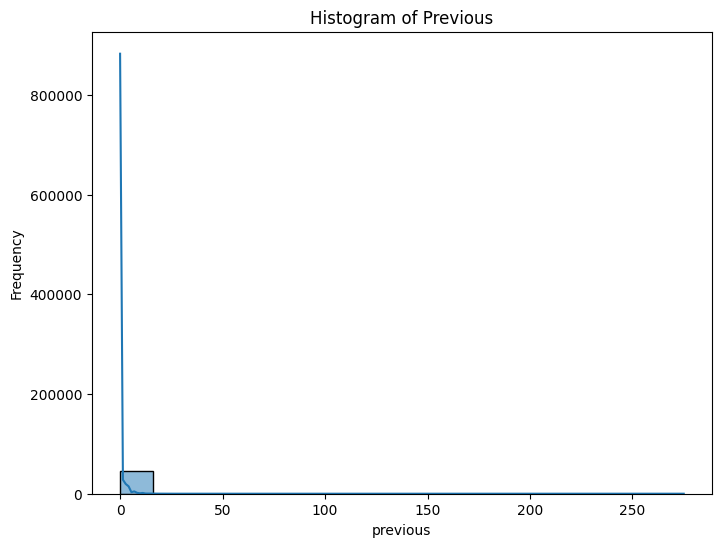

In [ ]:
for col in num_cols:
  plt.figure(figsize=(8,6))
  if col == "day":
    sns.histplot(df[col], kde=True, bins= 30)
  else:
    sns.histplot(df[col], kde=True)
  plt.title(f"Histogram of {col.capitalize()}")
  plt.xlabel(col)
  plt.ylabel("Frequency")
  plt.show()



*   The **age** distribution is right-skewed, ranging from 18 to over 90 years old with most customers aged 30–40. A key economically active segment for financial products.

*   The **balance** distribution is highly right-skewed, spanning from –8,000 to over 100,000. Most customers hold 0–10,000, suggesting uneven wealth and the need for balance-based segmentation.

*   The **day** distribution ranges from 1 to 31, with peaks around the 21st and 31st, likely linked to salary periods or month-end promotions — useful for campaign timing.

*   The **campaign** distribution is right-skewed, ranging from 0 to over 60 contact attempts. Most contacted fewer than 5 times, implying efficient outreach but potential fatigue from repeated contacts.

*   The **previous** contact distribution is also heavily right-skewed, with most customers never being contacted before, a few over 250 times. Indicates focus on new customers but suggests analyzing recontact results.

*   The **pdays** variable shows a strong concentration at –1, meaning no prior contact; few show long gaps (800+ days). Reflects focus on new leads, highlighting retargeting potential.

### 1.4.2.&nbsp; Customer Behavior

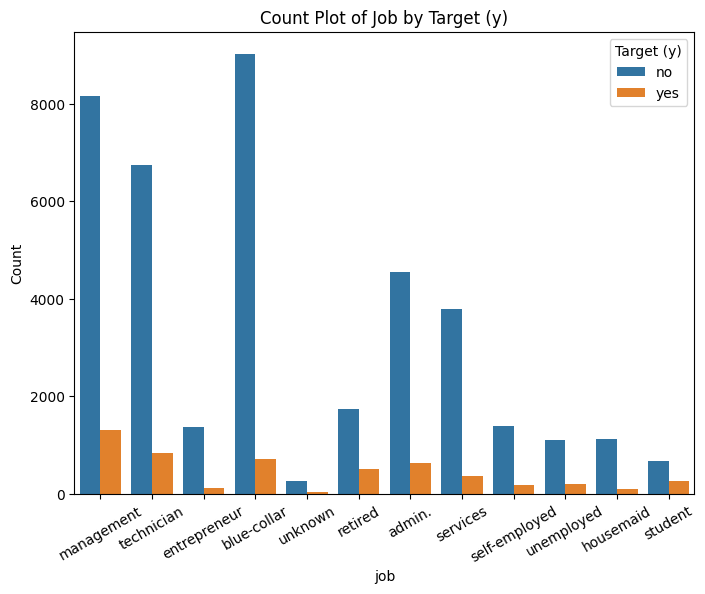

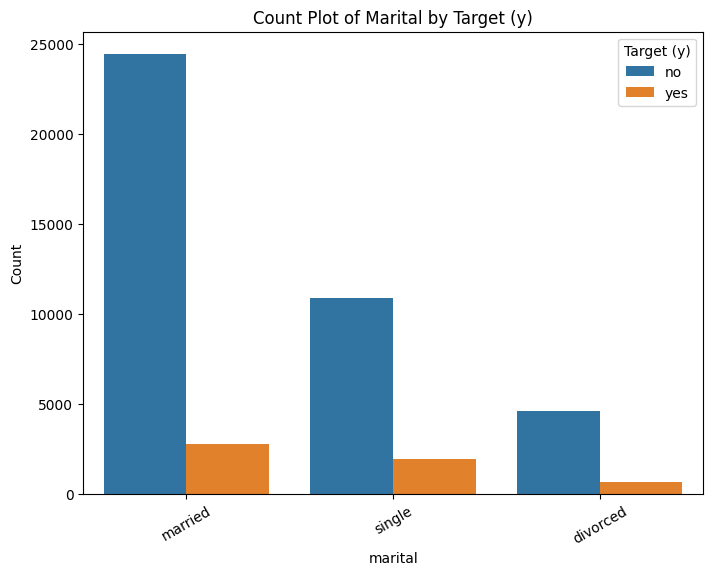

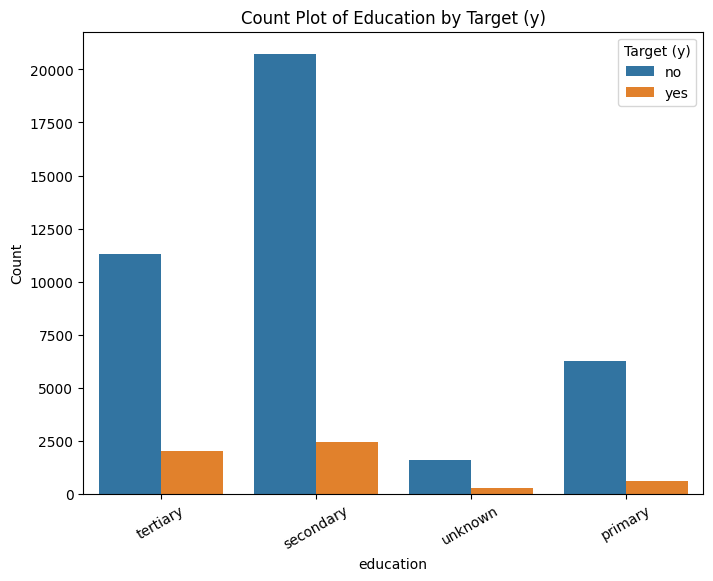

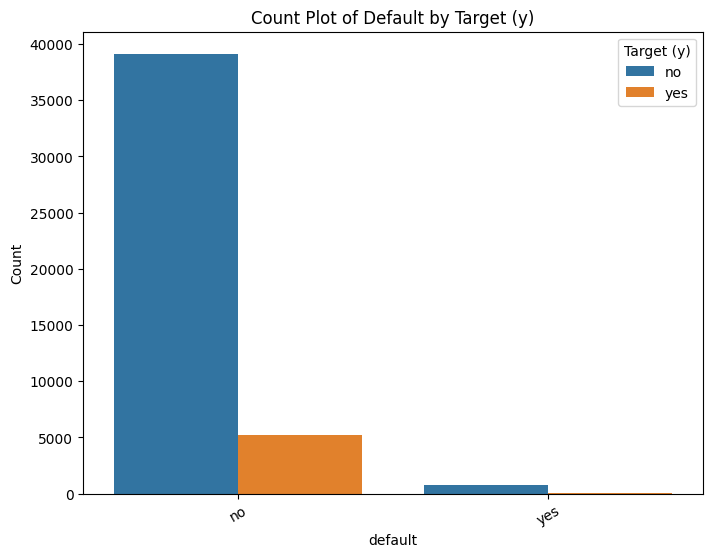

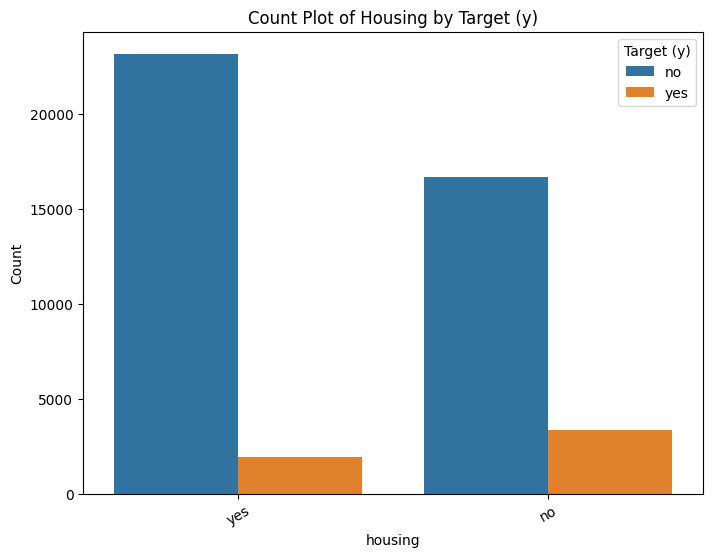

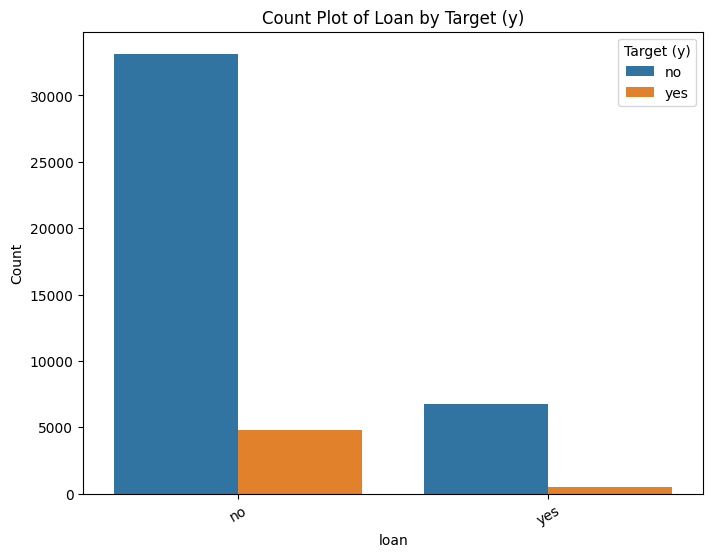

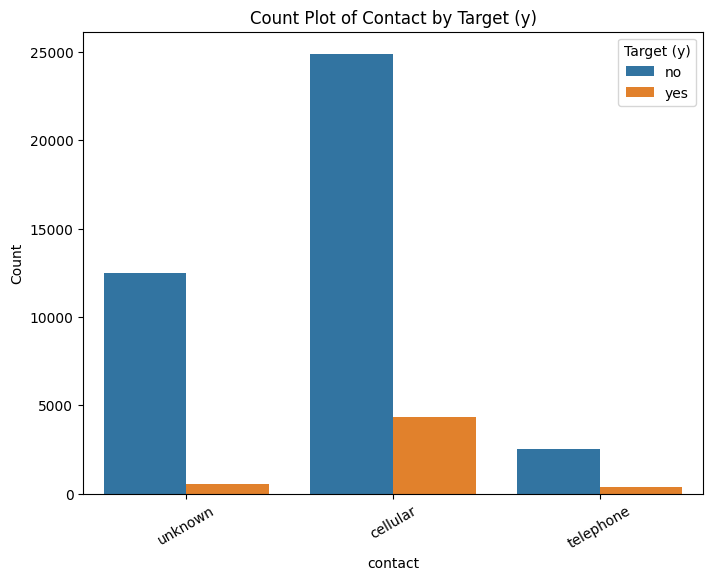

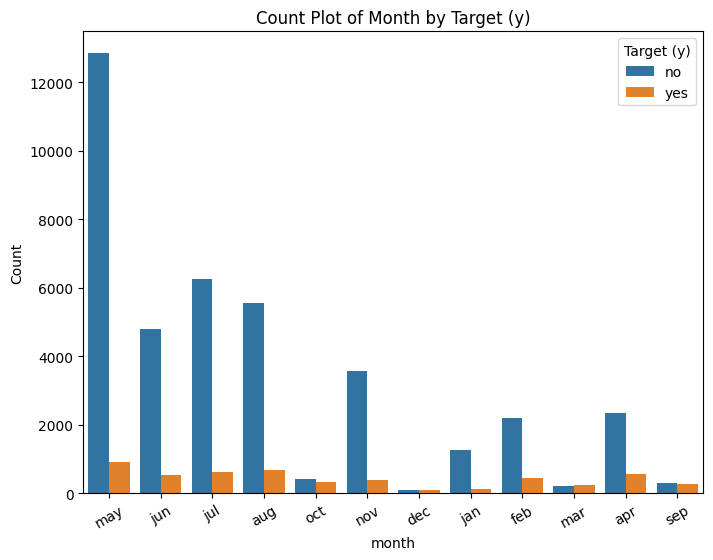

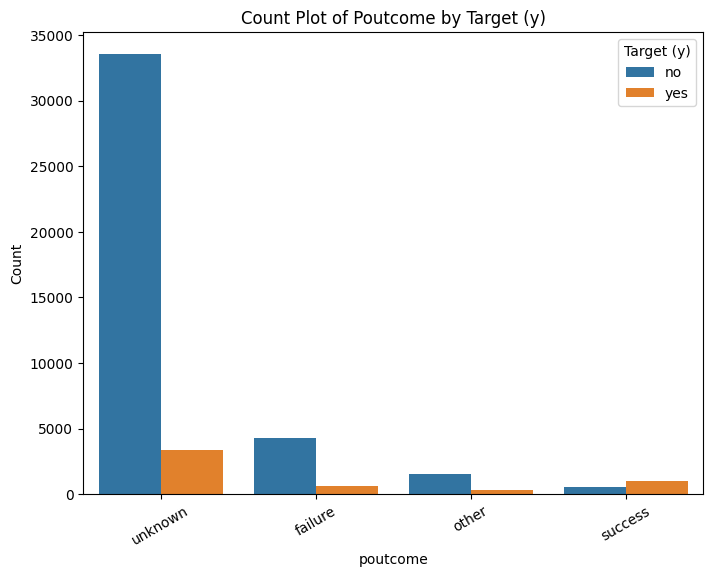

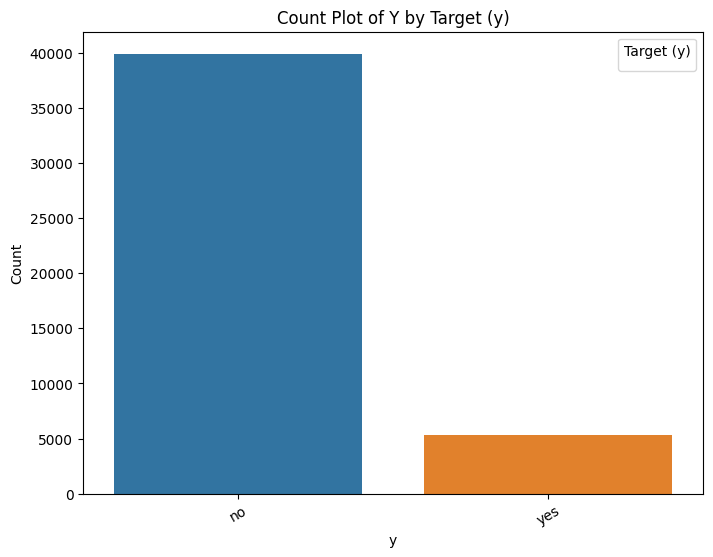

In [ ]:
for col in cat_cols:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=col, hue='y', data=df)
    plt.title(f"Count Plot of {col.capitalize()} by Target (y)")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=30)
    plt.legend(title='Target (y)')
    plt.show()

### 1.4.3.&nbsp; Outlier Distribution (Numerical)

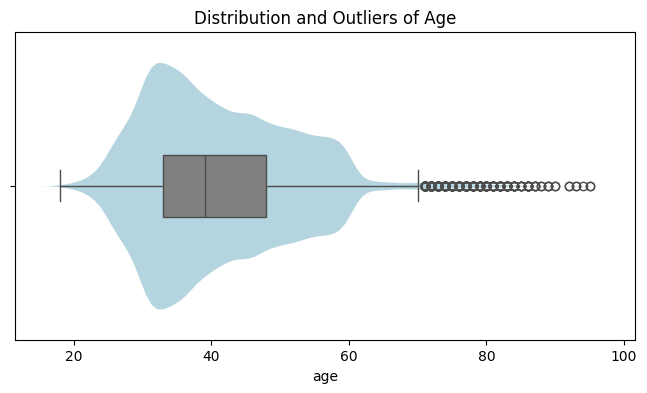

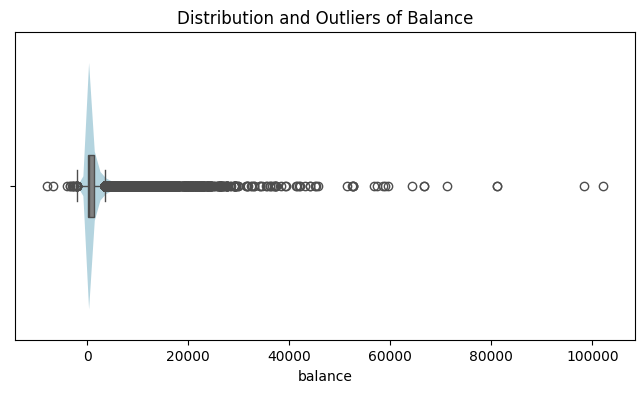

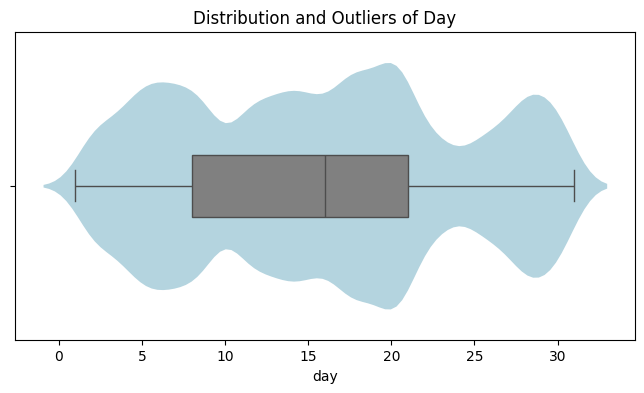

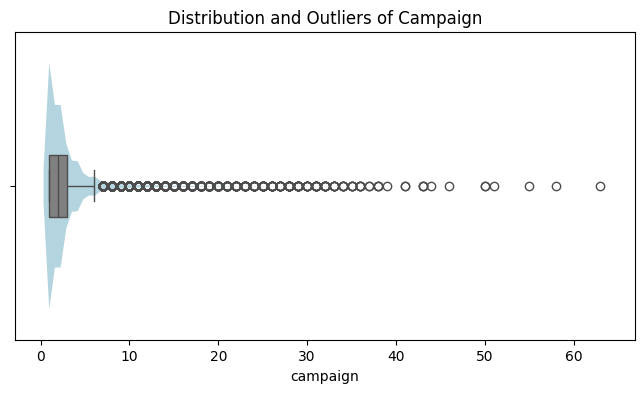

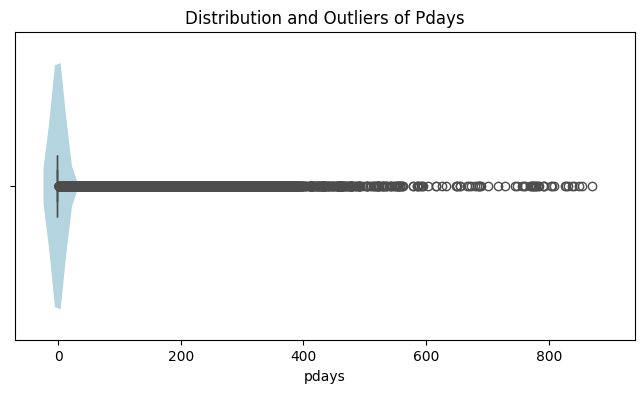

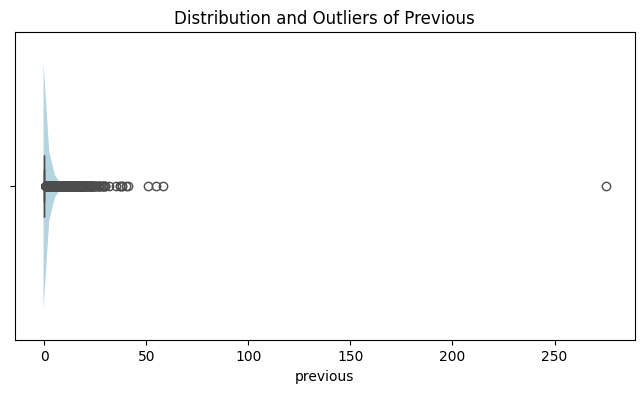

In [ ]:
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.violinplot(x=df[col], inner=None, color='lightblue', linewidth=0)
    sns.boxplot(x=df[col], width=0.2, color='gray')
    plt.title(f'Distribution and Outliers of {col.capitalize()}')
    plt.xlabel(col)
    plt.show()


### 1.4.4.&nbsp; Customer Subscription Distribution

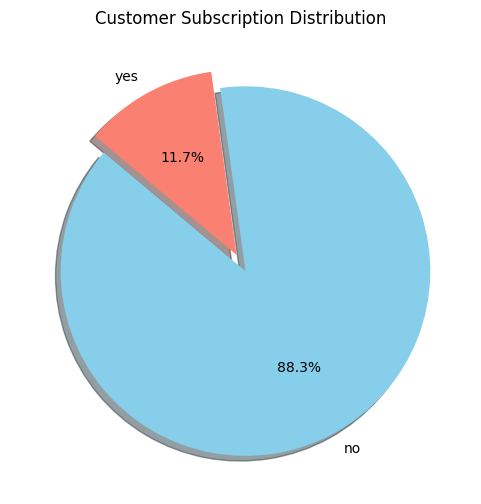

In [ ]:
target_counts = df['y'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    target_counts.values,
    labels=target_counts.index,
    autopct='%1.1f%%',
    colors=['skyblue', 'salmon'],
    explode=[0.05] * len(target_counts),
    shadow=True,
    startangle=140
)
plt.title('Customer Subscription Distribution')
plt.show()

*   The target variable shows a strong imbalance, with 11.7% “yes” and 88.3% “no”. This indicates that most customers did not subscribe, suggesting that the marketing strategy focused on reaching a broad audience rather than targeting high-potential leads.
*   The class imbalance also implies the need for data balancing techniques before model training to avoid bias toward the majority class.



# 2.&nbsp; Data Preprocessing

This section aims to clean, modify, and correct data so that it can be analyzed accurately.

In [ ]:
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,unknown,no


In [ ]:
df_eng = df.copy()

## 2.1.&nbsp; Feature Engineering

In [ ]:
df_eng['balance_positive'] = (df_eng['balance'] > 0).astype(int)
df_eng['not_contacted'] = (df_eng['pdays'] == -1).astype(int)
df_eng['prev_contacted'] = (df_eng['previous'] > 0).astype(int)
df_eng['contact_rate_prev'] = np.where(df_eng['campaign'] > 0,
                                       df_eng['previous'] / df_eng['campaign'],
                                       0)

In [ ]:
df_eng

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y,balance_positive,not_contacted,prev_contacted,contact_rate_prev
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no,1,1,0,0.0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no,1,1,0,0.0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no,1,1,0,0.0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no,1,1,0,0.0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no,1,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,unknown,yes,1,1,0,0.0
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,0,unknown,yes,1,1,0,0.0
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,success,yes,1,0,1,0.6
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,unknown,no,1,1,0,0.0


In [ ]:
df.shape

(45195, 16)

In [ ]:
df_eng.shape

(45195, 20)

EDA is sufficient at this point. Next, further preprocessing is carried out to make it easier for machine learning to learn.

In [ ]:
df_eng.to_csv("banking_targeting_preprocessed.csv", index=False)

## 2.2.&nbsp; Feature Encoding

In [ ]:
df_encoded = df_eng.copy()

In [ ]:
df_encoded

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y,balance_positive,not_contacted,prev_contacted,contact_rate_prev
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no,1,1,0,0.0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no,1,1,0,0.0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no,1,1,0,0.0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,1,-1,0,unknown,no,1,1,0,0.0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,1,-1,0,unknown,no,1,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,3,-1,0,unknown,yes,1,1,0,0.0
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,2,-1,0,unknown,yes,1,1,0,0.0
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,5,184,3,success,yes,1,0,1,0.6
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,4,-1,0,unknown,no,1,1,0,0.0


### 2.2.1.&nbsp; Label Encoding

In [ ]:
df_encoded["default"] = np.where(df_encoded["default"] == "yes", 1, 0)
df_encoded["housing"] = np.where(df_encoded["housing"] == "yes", 1, 0)
df_encoded["loan"] = np.where(df_encoded["loan"] == "yes", 1, 0)
df_encoded["y"] = np.where(df_encoded["y"] == "yes", 1, 0)

In [ ]:
df_encoded

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y,balance_positive,not_contacted,prev_contacted,contact_rate_prev
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,1,-1,0,unknown,0,1,1,0,0.0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,1,-1,0,unknown,0,1,1,0,0.0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,1,-1,0,unknown,0,1,1,0,0.0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,1,-1,0,unknown,0,1,1,0,0.0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,1,-1,0,unknown,0,1,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,0,825,0,0,cellular,17,nov,3,-1,0,unknown,1,1,1,0,0.0
45207,71,retired,divorced,primary,0,1729,0,0,cellular,17,nov,2,-1,0,unknown,1,1,1,0,0.0
45208,72,retired,married,secondary,0,5715,0,0,cellular,17,nov,5,184,3,success,1,1,0,1,0.6
45209,57,blue-collar,married,secondary,0,668,0,0,telephone,17,nov,4,-1,0,unknown,0,1,1,0,0.0


### 2.2.2.&nbsp; One Hot Encoding

In [ ]:
df_ohe = ['marital', 'contact', 'poutcome']
df_encoded = pd.get_dummies(df_encoded,
                            columns= df_ohe,
                            drop_first= False,
                            dtype= int)

In [ ]:
df_encoded

,age,job,education,default,balance,housing,loan,day,month,campaign,...,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,management,tertiary,0,2143,1,0,5,may,1,...,0,1,0,0,0,1,0,0,0,1
1,44,technician,secondary,0,29,1,0,5,may,1,...,0,0,1,0,0,1,0,0,0,1
2,33,entrepreneur,secondary,0,2,1,1,5,may,1,...,0,1,0,0,0,1,0,0,0,1
3,47,blue-collar,unknown,0,1506,1,0,5,may,1,...,0,1,0,0,0,1,0,0,0,1
4,33,unknown,unknown,0,1,0,0,5,may,1,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,tertiary,0,825,0,0,17,nov,3,...,0,1,0,1,0,0,0,0,0,1
45207,71,retired,primary,0,1729,0,0,17,nov,2,...,1,0,0,1,0,0,0,0,0,1
45208,72,retired,secondary,0,5715,0,0,17,nov,5,...,0,1,0,1,0,0,0,0,1,0
45209,57,blue-collar,secondary,0,668,0,0,17,nov,4,...,0,1,0,0,1,0,0,0,0,1


### 2.2.3.&nbsp; Ordinal Encoding

In [ ]:
edu_map = {
    "unknown": 0, "primary": 1,
    "secondary": 2, "tertiary": 3
}

month_map = {
    "jan": 1, "feb": 2, "mar": 3, "apr": 4,
    "may": 5, "jun": 6, "jul": 7, "aug": 8,
    "sep": 9, "oct": 10, "nov": 11, "dec": 12
}

df_encoded["month_num"] = df_encoded["month"].map(month_map)
df_encoded["edu_num"] = df_encoded["education"].map(edu_map)

### 2.2.4.&nbsp; Frequency Encoding

In [ ]:
cols_freq = ['job']

for col in cols_freq:
    freq_map = df_encoded[col].value_counts(normalize=True)
    df_encoded[col + '_freq'] = df_encoded[col].map(freq_map)
    df_encoded.drop(columns=[col], inplace= True)

In [ ]:
df_encoded

,age,education,default,balance,housing,loan,day,month,campaign,pdays,...,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,month_num,edu_num,job_freq
0,58,tertiary,0,2143,1,0,5,may,1,-1,...,0,0,1,0,0,0,1,5,3,0.209116
1,44,secondary,0,29,1,0,5,may,1,-1,...,0,0,1,0,0,0,1,5,2,0.168005
2,33,secondary,0,2,1,1,5,may,1,-1,...,0,0,1,0,0,0,1,5,2,0.032902
3,47,unknown,0,1506,1,0,5,may,1,-1,...,0,0,1,0,0,0,1,5,0,0.215289
4,33,unknown,0,1,0,0,5,may,1,-1,...,0,0,1,0,0,0,1,5,0,0.006372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,tertiary,0,825,0,0,17,nov,3,-1,...,1,0,0,0,0,0,1,11,3,0.168005
45207,71,primary,0,1729,0,0,17,nov,2,-1,...,1,0,0,0,0,0,1,11,1,0.050072
45208,72,secondary,0,5715,0,0,17,nov,5,184,...,1,0,0,0,0,1,0,11,2,0.050072
45209,57,secondary,0,668,0,0,17,nov,4,-1,...,0,1,0,0,0,0,1,11,2,0.215289


### 2.2.5.&nbsp; Cyclical Encoding

In [ ]:
df_encoded['day_sin'] = np.sin(2*np.pi*df_encoded['day']/31)
df_encoded['day_cos'] = np.cos(2*np.pi*df_encoded['day']/31)

df_encoded['month_sin'] = np.sin(2*np.pi*df_encoded['month_num']/12)
df_encoded['month_cos'] = np.cos(2*np.pi*df_encoded['month_num']/12)
df_encoded.drop(columns=['day', 'month', 'month_num', 'education'], inplace= True)


In [ ]:
df_encoded

,age,default,balance,housing,loan,campaign,pdays,previous,y,balance_positive,...,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,edu_num,job_freq,day_sin,day_cos,month_sin,month_cos
0,58,0,2143,1,0,1,-1,0,0,1,...,0,0,0,1,3,0.209116,0.848644,0.528964,0.5,-0.866025
1,44,0,29,1,0,1,-1,0,0,1,...,0,0,0,1,2,0.168005,0.848644,0.528964,0.5,-0.866025
2,33,0,2,1,1,1,-1,0,0,1,...,0,0,0,1,2,0.032902,0.848644,0.528964,0.5,-0.866025
3,47,0,1506,1,0,1,-1,0,0,1,...,0,0,0,1,0,0.215289,0.848644,0.528964,0.5,-0.866025
4,33,0,1,0,0,1,-1,0,0,1,...,0,0,0,1,0,0.006372,0.848644,0.528964,0.5,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,825,0,0,3,-1,0,1,1,...,0,0,0,1,3,0.168005,-0.299363,-0.954139,-0.5,0.866025
45207,71,0,1729,0,0,2,-1,0,1,1,...,0,0,0,1,1,0.050072,-0.299363,-0.954139,-0.5,0.866025
45208,72,0,5715,0,0,5,184,3,1,1,...,0,0,1,0,2,0.050072,-0.299363,-0.954139,-0.5,0.866025
45209,57,0,668,0,0,4,-1,0,0,1,...,0,0,0,1,2,0.215289,-0.299363,-0.954139,-0.5,0.866025


In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45195 entries, 0 to 45210
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                45195 non-null  int64  
 1   default            45195 non-null  int64  
 2   balance            45195 non-null  int64  
 3   housing            45195 non-null  int64  
 4   loan               45195 non-null  int64  
 5   campaign           45195 non-null  int64  
 6   pdays              45195 non-null  int64  
 7   previous           45195 non-null  int64  
 8   y                  45195 non-null  int64  
 9   balance_positive   45195 non-null  int64  
 10  not_contacted      45195 non-null  int64  
 11  prev_contacted     45195 non-null  int64  
 12  contact_rate_prev  45195 non-null  float64
 13  marital_divorced   45195 non-null  int64  
 14  marital_married    45195 non-null  int64  
 15  marital_single     45195 non-null  int64  
 16  contact_cellular   45195 no

In [ ]:
df_encoded.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45195.0,40.937604,10.619108,18.000000,33.000000,3.900000e+01,48.000000,95.000000
default,45195.0,0.018033,0.133072,0.000000,0.000000,0.000000e+00,0.000000,1.000000
balance,45195.0,1362.754331,3045.196838,-8019.000000,72.000000,4.490000e+02,1428.000000,102127.000000
housing,45195.0,0.555946,0.496866,0.000000,0.000000,1.000000e+00,1.000000,1.000000
loan,45195.0,0.160283,0.366873,0.000000,0.000000,0.000000e+00,0.000000,1.000000
campaign,45195.0,2.763978,3.098304,1.000000,1.000000,2.000000e+00,3.000000,63.000000
pdays,45195.0,40.212413,100.143468,-1.000000,-1.000000,-1.000000e+00,-1.000000,871.000000
previous,45195.0,0.580529,2.303823,0.000000,0.000000,0.000000e+00,0.000000,275.000000
y,45195.0,0.117026,0.321455,0.000000,0.000000,0.000000e+00,0.000000,1.000000
balance_positive,45195.0,0.839274,0.367282,0.000000,1.000000,1.000000e+00,1.000000,1.000000


## 2.3.&nbsp; Correlation Analysis

Correlation analysis was performed after feature encoding and before transformation to evaluate relationships between features and the target variable. Spearman correlation was used due to the presence of skewed numerical features and potential non-linear relationships. This step also aimed to detect potential multicollinearity, especially among encoded categorical variables.

<Axes: >

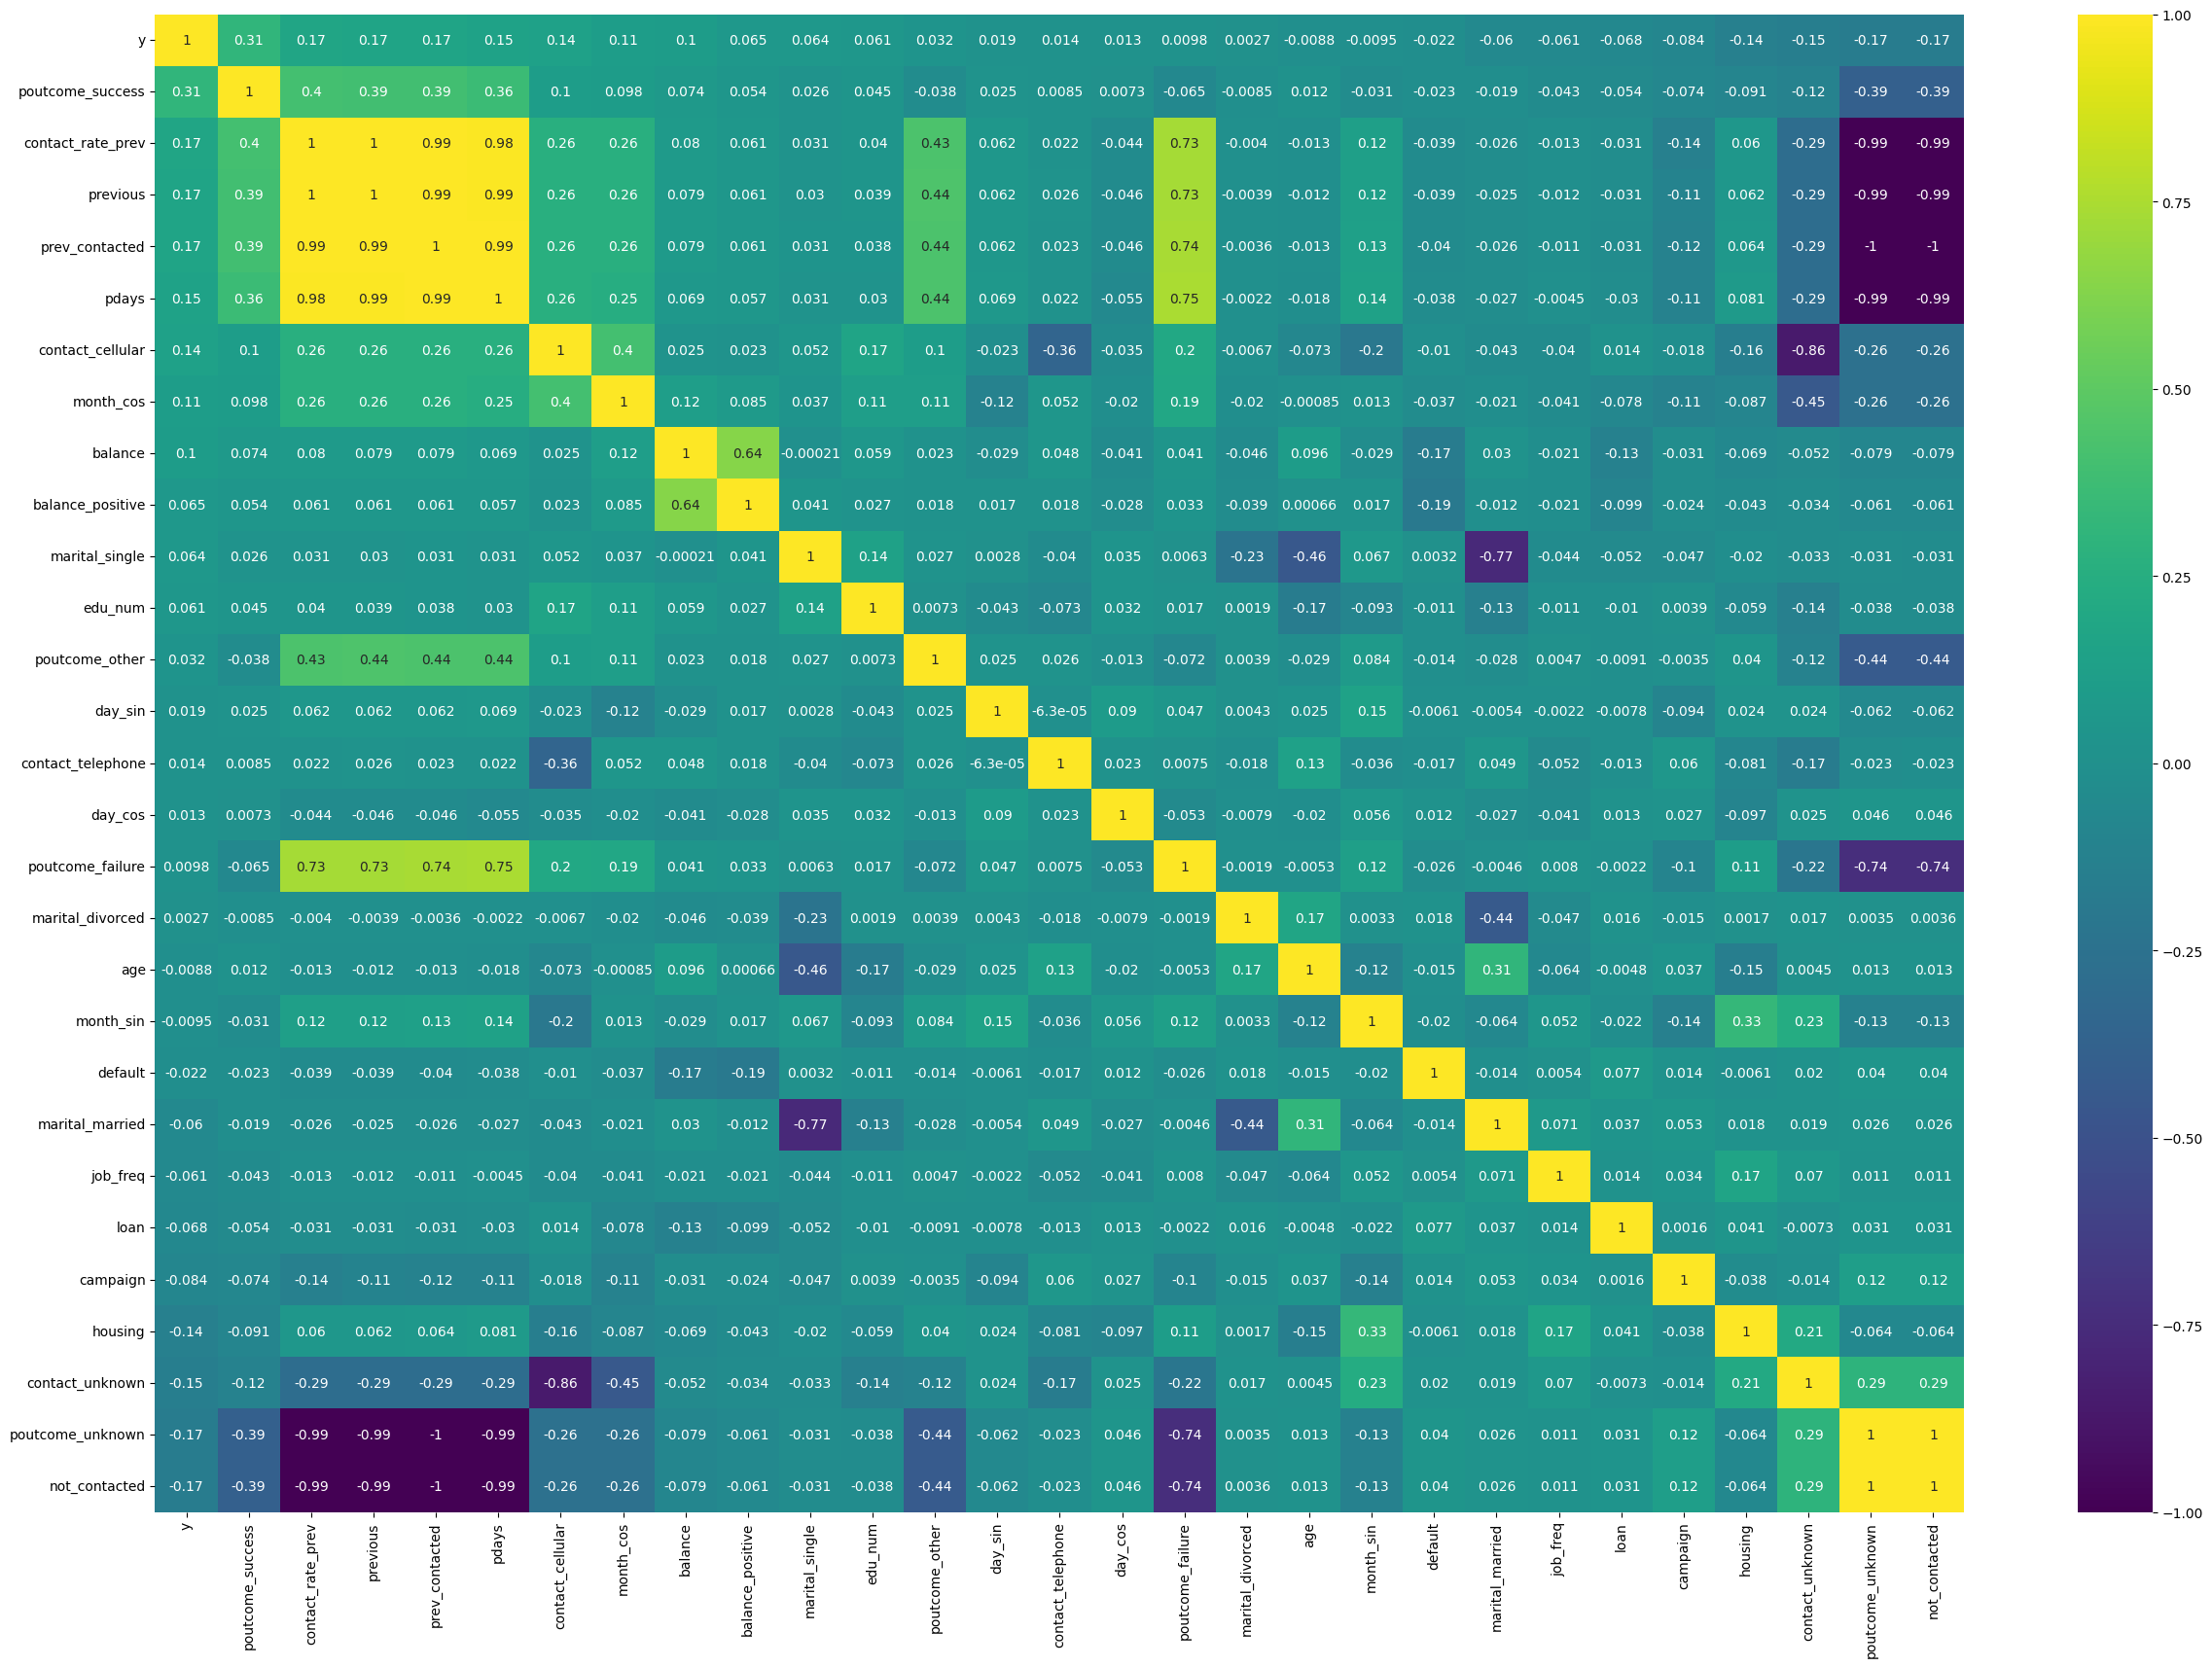

In [ ]:
# Correlation Analysis

k = len(df_encoded.columns)
cols = df_encoded.corr(method= 'spearman').nlargest(k, 'y')['y'].index
corr_mat = df_encoded[cols].corr(method= 'spearman')

plt.figure(figsize=(30, 20))
sns.heatmap(
    corr_mat,
    cmap='viridis',
    annot=True,
)

Due to the presence of multicollinearity among several features, one of the correlated columns needs to be removed. Specifically, the features **`prev_contacted`**, **`contact_rate_prev`**, and **`not_contacted`** were dropped because they were derived from feature engineering processes that did not provide additional or unique insights to the model.


In [ ]:
df_encoded.drop(columns=["prev_contacted", "contact_rate_prev", "not_contacted"], inplace=True)

<Axes: >

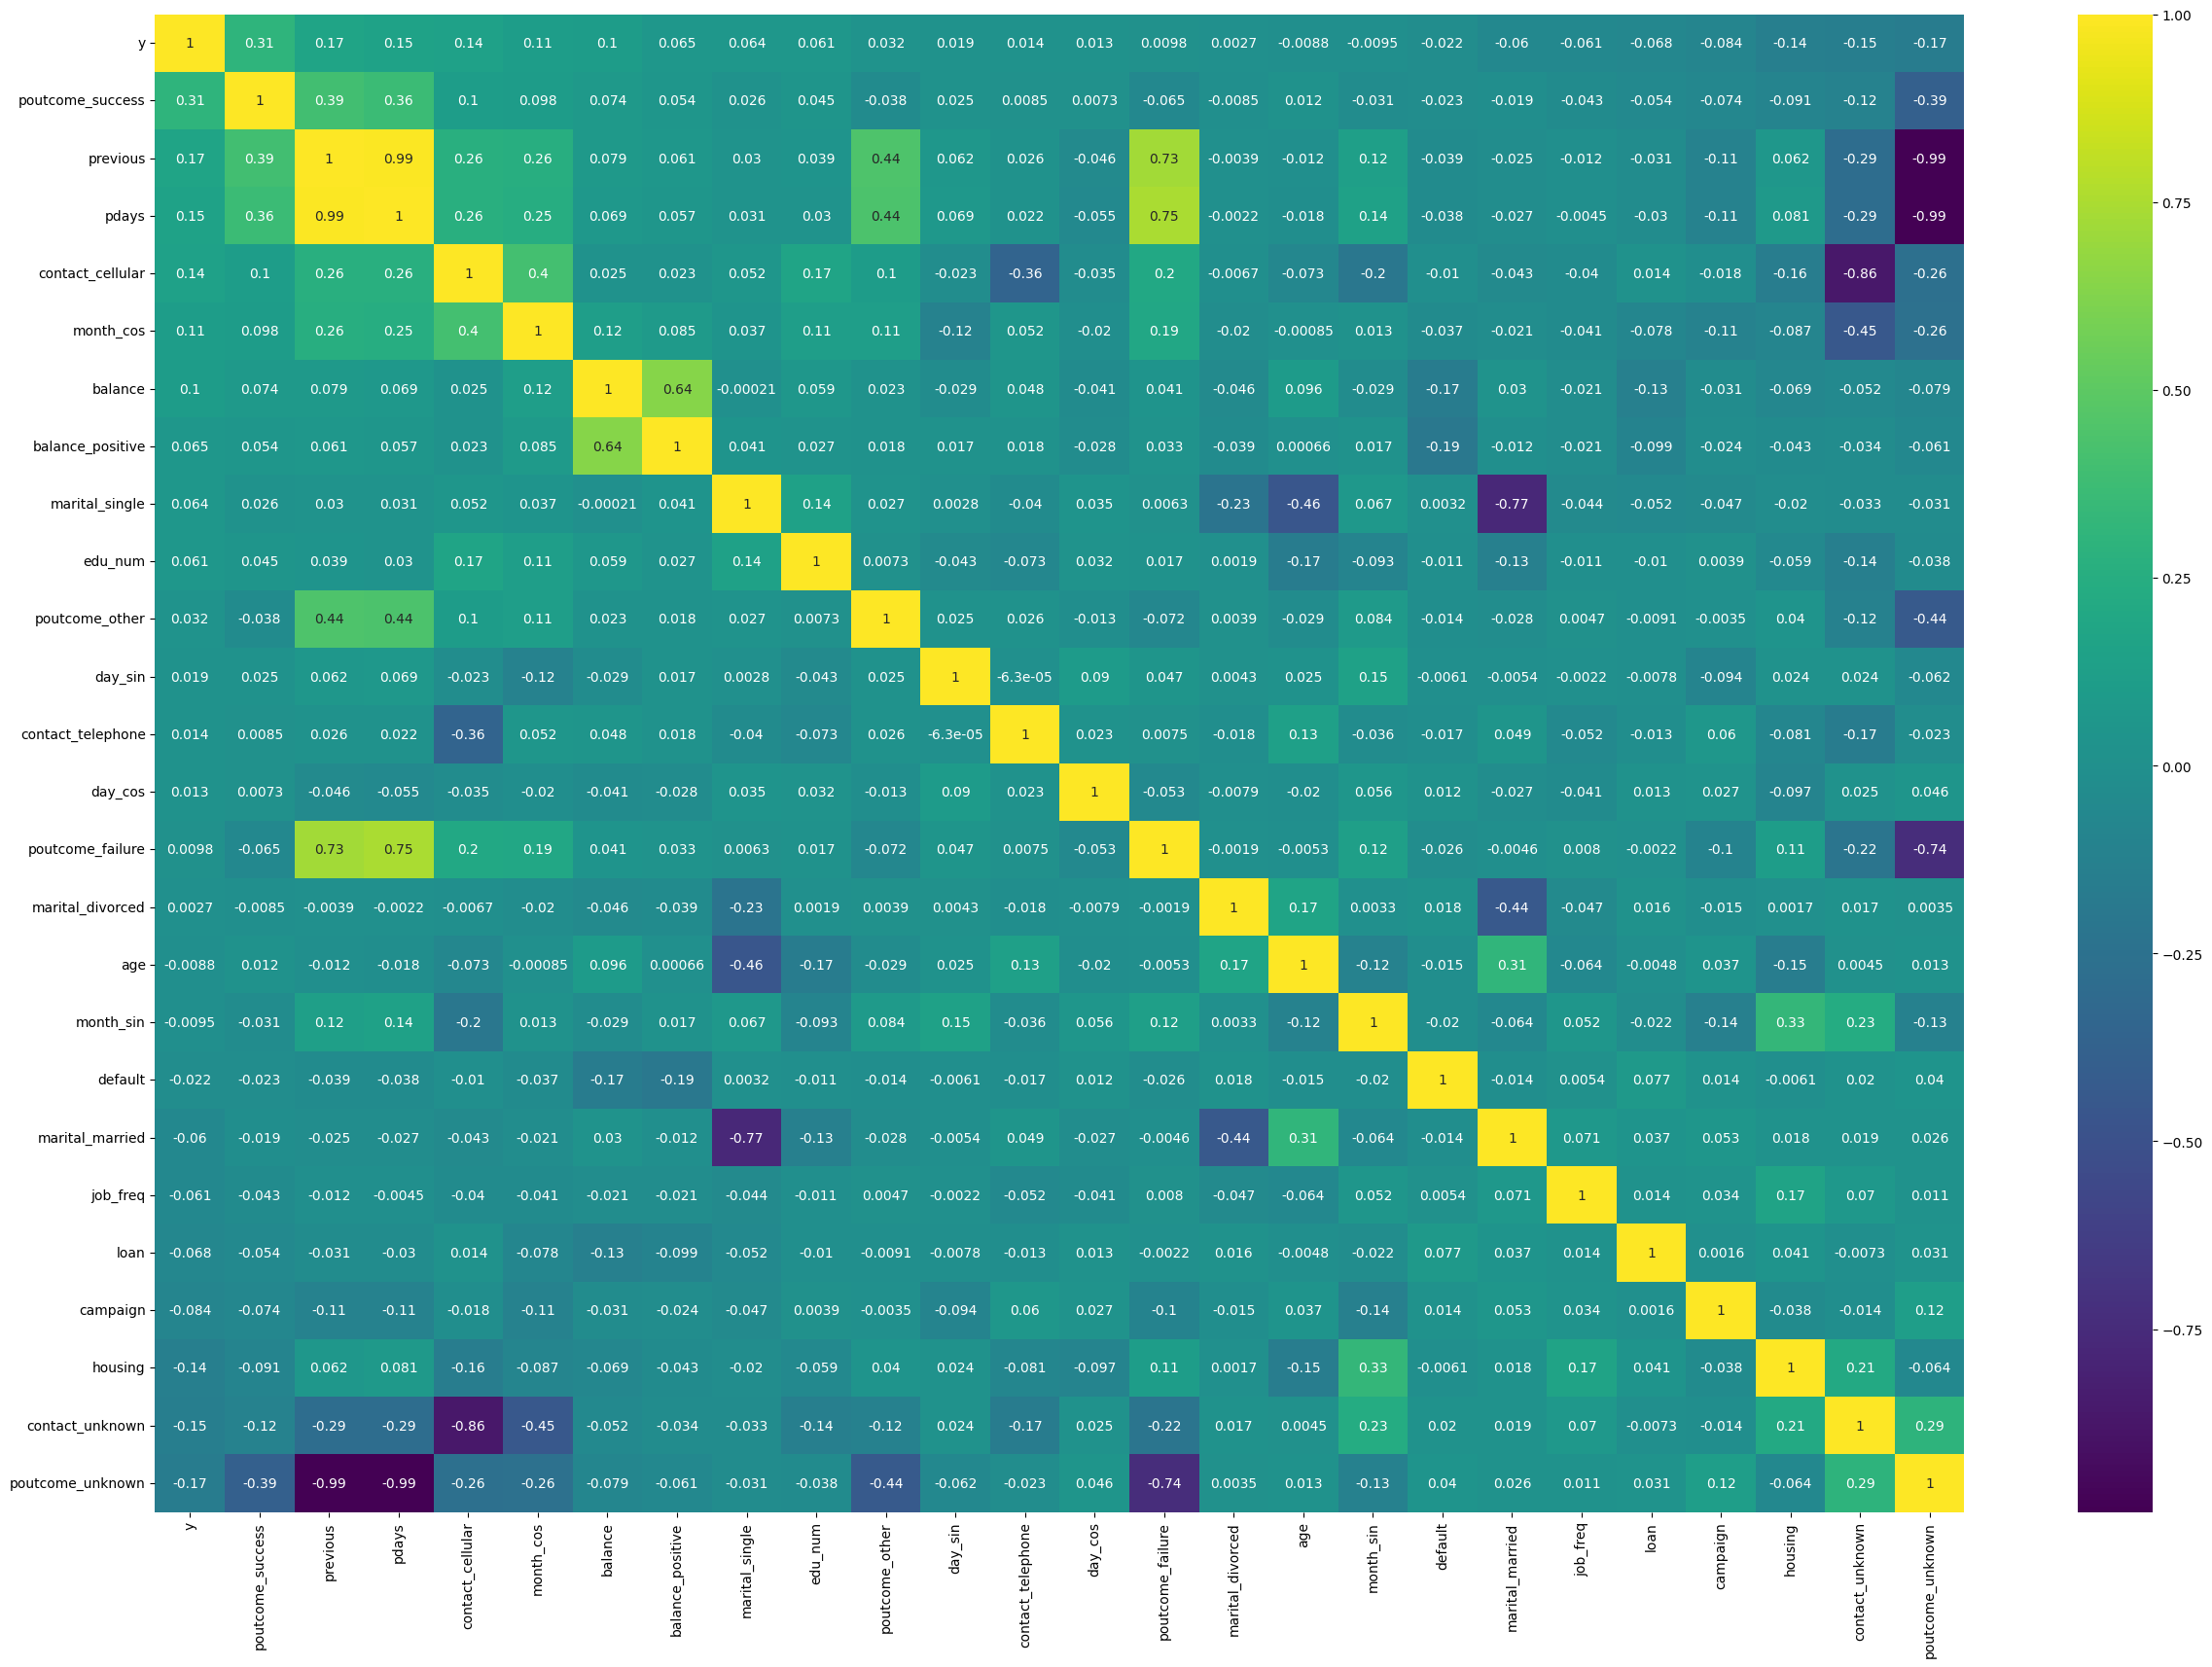

In [ ]:
# Correlation Analysis

k = len(df_encoded.columns)
cols = df_encoded.corr(method= 'spearman').nlargest(k, 'y')['y'].index
corr_mat = df_encoded[cols].corr(method= 'spearman')

plt.figure(figsize=(30, 20))
sns.heatmap(
    corr_mat,
    cmap='viridis',
    annot=True,
)

## 2.4.&nbsp; Transformation

In [ ]:
df_encoded.skew().sort_values(ascending=False)

,0
previous,41.840198
balance,8.359274
default,7.244021
poutcome_success,5.191053
campaign,4.898646
poutcome_other,4.648266
contact_telephone,3.552726
pdays,2.615075
poutcome_failure,2.518658
marital_divorced,2.410448


In [ ]:
transform_cols = []

skew_vals = df_encoded.skew()

for col in df_encoded.columns:
  if df_encoded[col].nunique() <= 2:
        continue

  if -0.5 <= skew_vals[col] <= 0.5:
    continue
  else:
    transform_cols.append(col)

transform_cols

['age',
 'balance',
 'campaign',
 'pdays',
 'previous',
 'edu_num',
 'job_freq',
 'month_cos']

To improve machine learning performance, values outside the normal distribution range (-0.5 < x < 0.5) need to be normalized.
However, this is not necessary for columns with binary and cyclical encoded categories, as well as the following columns:

*   The **`previous`** column has over 80% zero values, resulting in a zero-inflated distribution. Transformations were not applied, as they would distort the feature’s meaning. The zeros were kept since they represent customers who were never contacted before.

*   **`age`**, because the skew value is still moderate and the visualization results do not show a long tail. Therefore, scaling is sufficient.

*   **`job_freq`**, this column also has moderate skewness and the visualization results show no outliers and have a short tail. Therefore, scaling is sufficient for this column.

*   **`edu_num`**, although this column has a few outliers, it also has characteristics similar to **`job_freq`**. Therefore, scaling is sufficient.

*   **`month_cos`** column shows a skewness value of ~1.264, no transformation is applied since the feature was generated using cyclical encoding. The non-linear distribution reflects the periodic nature of the month feature, and further transformation would distort this cyclical relationship.



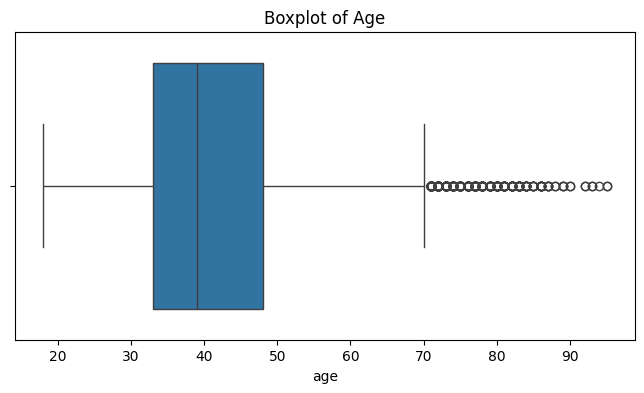

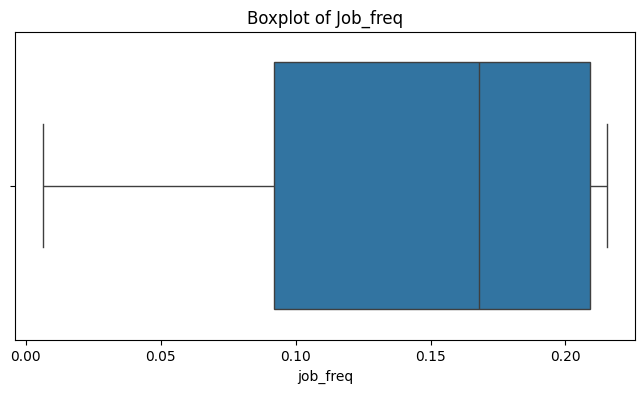

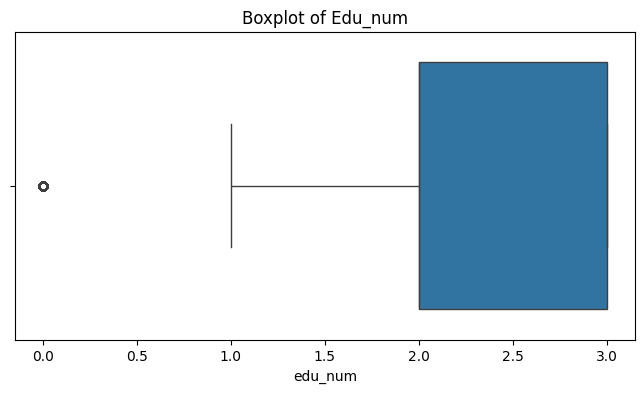

In [ ]:
cols = ['age', 'job_freq', 'edu_num']

for col in cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_encoded[col])
    plt.title(f'Boxplot of {col.capitalize()}')
    plt.show()

In [ ]:
not_inc = ['previous', 'age', 'job_freq', 'edu_num', 'month_cos']
transform_cols = [x for x in transform_cols if x not in not_inc]
transform_cols

['balance', 'campaign', 'pdays']

In [ ]:
  #before transform
df_encoded[transform_cols].skew().sort_values(ascending= False)

,0
balance,8.359274
campaign,4.898646
pdays,2.615075


In [ ]:
df_tran = df_encoded.copy()

In [ ]:
#Yeo-Johnson for positive and negative Heavy Skew
cols_pt = ['balance', 'pdays', 'campaign']
pt = PowerTransformer(method= 'yeo-johnson')
df_tran[cols_pt] = pt.fit_transform(df_tran[cols_pt])

In [ ]:
comp_skew = []

for feat in transform_cols:
    skew_before = df_encoded[feat].skew()
    skew_after = df_tran[feat].skew()

    comp_skew.append({
        'Feature': feat,
        'Skewness Before transform': skew_before,
        'Skewness After transform': skew_after,
        'Difference': skew_before - skew_after
    })

comp_skew_df = pd.DataFrame(comp_skew).sort_values(
    by='Skewness Before transform', ascending=False
)

comp_skew_df

,Feature,Skewness Before transform,Skewness After transform,Difference
0,balance,8.359274,1.101490,7.257784
1,campaign,4.898646,0.230959,4.667687
2,pdays,2.615075,1.644655,0.970420


In [ ]:
df_tran

,age,default,balance,housing,loan,campaign,pdays,previous,y,balance_positive,...,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,edu_num,job_freq,day_sin,day_cos,month_sin,month_cos
0,58,0,0.414549,1,0,-1.108143,-0.472635,0,0,1,...,0,0,0,1,3,0.209116,0.848644,0.528964,0.5,-0.866025
1,44,0,-0.410916,1,0,-1.108143,-0.472635,0,0,1,...,0,0,0,1,2,0.168005,0.848644,0.528964,0.5,-0.866025
2,33,0,-0.431260,1,1,-1.108143,-0.472635,0,0,1,...,0,0,0,1,2,0.032902,0.848644,0.528964,0.5,-0.866025
3,47,0,0.197477,1,0,-1.108143,-0.472635,0,0,1,...,0,0,0,1,0,0.215289,0.848644,0.528964,0.5,-0.866025
4,33,0,-0.432257,0,0,-1.108143,-0.472635,0,0,1,...,0,0,0,1,0,0.006372,0.848644,0.528964,0.5,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,-0.052584,0,0,0.737579,-0.472635,0,1,1,...,0,0,0,1,3,0.168005,-0.299363,-0.954139,-0.5,0.866025
45207,71,0,0.274909,0,0,0.134493,-0.472635,0,1,1,...,0,0,0,1,1,0.050072,-0.299363,-0.954139,-0.5,0.866025
45208,72,0,1.495481,0,0,1.323665,2.121924,3,1,1,...,0,0,1,0,2,0.050072,-0.299363,-0.954139,-0.5,0.866025
45209,57,0,-0.114415,0,0,1.091645,-0.472635,0,0,1,...,0,0,0,1,2,0.215289,-0.299363,-0.954139,-0.5,0.866025


## 2.5.&nbsp; Data Splitting

Data splitting is performed before scaling to prevent data leakage, which occurs when information from the test set influences the training process. By splitting the data first, the scaler is fitted only on the training set to compute statistics such as the mean and standard deviation, which are then applied to both training and test data. This approach ensures that the model is evaluated on unseen data, providing a more reliable and unbiased assessment of its performance.


In [ ]:
df_tran.shape

(45195, 26)

In [ ]:
X = df_tran.drop(columns= 'y')
y = df_tran['y']

In [ ]:
 X

,age,default,balance,housing,loan,campaign,pdays,previous,balance_positive,marital_divorced,...,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,edu_num,job_freq,day_sin,day_cos,month_sin,month_cos
0,58,0,0.414549,1,0,-1.108143,-0.472635,0,1,0,...,0,0,0,1,3,0.209116,0.848644,0.528964,0.5,-0.866025
1,44,0,-0.410916,1,0,-1.108143,-0.472635,0,1,0,...,0,0,0,1,2,0.168005,0.848644,0.528964,0.5,-0.866025
2,33,0,-0.431260,1,1,-1.108143,-0.472635,0,1,0,...,0,0,0,1,2,0.032902,0.848644,0.528964,0.5,-0.866025
3,47,0,0.197477,1,0,-1.108143,-0.472635,0,1,0,...,0,0,0,1,0,0.215289,0.848644,0.528964,0.5,-0.866025
4,33,0,-0.432257,0,0,-1.108143,-0.472635,0,1,0,...,0,0,0,1,0,0.006372,0.848644,0.528964,0.5,-0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,0,-0.052584,0,0,0.737579,-0.472635,0,1,0,...,0,0,0,1,3,0.168005,-0.299363,-0.954139,-0.5,0.866025
45207,71,0,0.274909,0,0,0.134493,-0.472635,0,1,1,...,0,0,0,1,1,0.050072,-0.299363,-0.954139,-0.5,0.866025
45208,72,0,1.495481,0,0,1.323665,2.121924,3,1,0,...,0,0,1,0,2,0.050072,-0.299363,-0.954139,-0.5,0.866025
45209,57,0,-0.114415,0,0,1.091645,-0.472635,0,1,0,...,0,0,0,1,2,0.215289,-0.299363,-0.954139,-0.5,0.866025


In [ ]:
y

,y
0,0
1,0
2,0
3,0
4,0
...,...
45206,1
45207,1
45208,1
45209,0


In [ ]:
y.value_counts()

,count
y,
0,39906
1,5289


In [ ]:
y.value_counts(normalize= True)

,proportion
y,
0,0.882974
1,0.117026


Since the dataset is quite large, the test set is limited to 20% because it is already sufficiently representative. Furthermore, this dataset is not balanced, so **`stratify = y`** is used so that the minority and majority classes are divided equally.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size= 0.2,
    random_state= 42,
    stratify= y
)

# 3.&nbsp; Modelling

In [ ]:
X_train.skew().sort_values(ascending= False)

,0
previous,45.867844
default,7.333635
poutcome_success,5.185866
poutcome_other,4.634025
contact_telephone,3.546956
poutcome_failure,2.528282
marital_divorced,2.408600
loan,1.850155
pdays,1.647083
month_cos,1.275817


In [ ]:
rs_cols = []
st_cols = []
cyclical_cols = ['day_sin', 'day_cos', 'month_sin', 'month_cos']

skew_vals = X_train.skew()

for col in X_train.columns:

  if X_train[col].nunique() <= 2:
    continue

  elif col in cyclical_cols:
    continue

  elif -0.5 <= skew_vals[col] <= 0.5:
    st_cols.append(col)

  else:
    rs_cols.append(col)

print("StandardScaler cols:", st_cols)
print("RobustScaler cols:", rs_cols)

StandardScaler cols: ['campaign']
RobustScaler cols: ['age', 'balance', 'pdays', 'previous', 'edu_num', 'job_freq']


standardscaler is used on columns that are already normally distributed.

robustscaler is used on columns that are not yet normally distributed.

In [ ]:
preprocessor = ColumnTransformer([
    ('standard', StandardScaler(), st_cols),
    ('robust', RobustScaler(), rs_cols)
], remainder= 'passthrough')

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('resample', SMOTETomek(sampling_strategy=0.5, random_state=42)),
    ('model', None)
])

## 3.1.&nbsp; Model Selection

In order to select the model to be used, **ROC-AUC** was chosen as the main evaluation metric because it effectively measures the model’s ability to distinguish between clients who will and will not subscribe, regardless of class imbalance. It evaluates performance across all thresholds, providing a fair and comprehensive view of ranking quality. This makes it ideal for marketing use cases, where identifying the most promising leads is more important than overall accuracy.

In [ ]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'ROC-AUC': 'roc_auc',
    'Precision': 'precision',
    'Recall': 'recall',
    'F1': 'f1'
}

models = [
    ("LogisticRegresion", LogisticRegression(max_iter= 1000, random_state= 42)),
    ("Naive Bayes", GaussianNB()),
    ("XGBoost", XGBClassifier(random_state= 42)),
    ("LightGBM", LGBMClassifier(random_state= 42)),
    ("Random Forest", RandomForestClassifier(random_state= 42)),
    ("CATBoost", CatBoostClassifier(random_state= 42, verbose= 0))
]

results=[]

for name, model in models:
    print(f"\nEvaluating {name}...")

    pipe.set_params(model=model)

    cv_results = cross_validate(
        pipe,
        X_train,
        y_train,
        cv=skf,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )

    results.append({
        'Algorithm': name,
        'CV - Recall': round(np.mean(cv_results['test_Recall']) * 100,2),
        'CV - Precision': round(np.mean(cv_results['test_Precision']) * 100,2),
        'CV - F1': round(np.mean(cv_results['test_F1']) * 100,2),
        'CV - ROC-AUC': round(np.mean(cv_results['test_ROC-AUC']) * 100,2)
    })

model_results = pd.DataFrame(results)
model_results = model_results.sort_values(by="CV - ROC-AUC", ascending=False).reset_index(drop=True)

display(model_results)


Evaluating LogisticRegresion...

Evaluating Naive Bayes...

Evaluating XGBoost...

Evaluating LightGBM...

Evaluating Random Forest...

Evaluating CATBoost...


,Algorithm,CV - Recall,CV - Precision,CV - F1,CV - ROC-AUC
0,CATBoost,27.27,59.88,37.46,79.53
1,LightGBM,28.88,59.26,38.82,79.43
2,XGBoost,27.51,59.16,37.55,78.48
3,Random Forest,29.57,55.13,38.48,78.06
4,LogisticRegresion,34.79,42.03,38.04,74.34
5,Naive Bayes,54.43,24.22,33.50,72.05


In [ ]:
model_results.to_csv("model_selection_results.csv", index=False)

print("✅ Hasil model selection berhasil disimpan ke 'model_selection_results.csv'")

✅ Hasil model selection berhasil disimpan ke 'model_selection_results.csv'


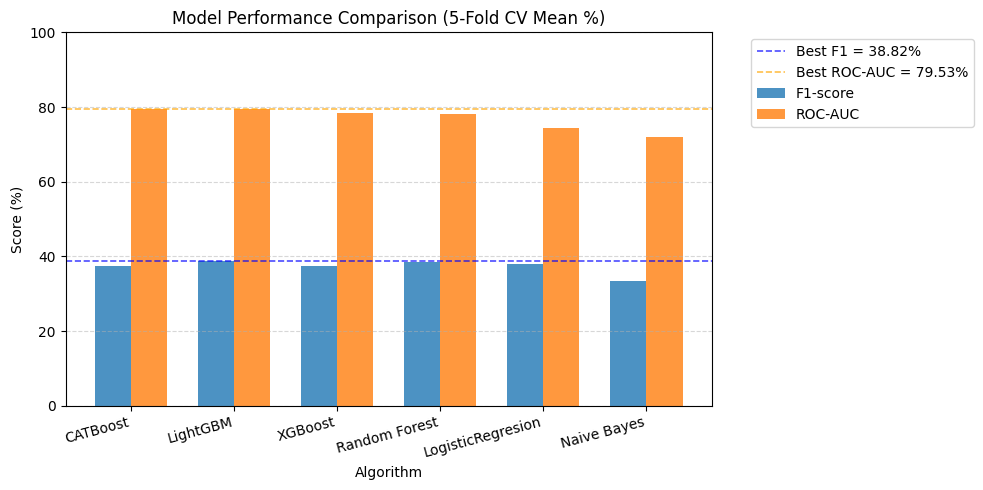

In [ ]:
x = np.arange(len(model_results))
width = 0.35

plt.figure(figsize=(10, 5))

plt.bar(x - width/2, model_results["CV - F1"], width, label="F1-score", alpha=0.8)
plt.bar(x + width/2, model_results["CV - ROC-AUC"], width, label="ROC-AUC", alpha=0.8)

best_f1 = model_results["CV - F1"].max()
best_roc_auc = model_results["CV - ROC-AUC"].max()

plt.axhline(y=best_f1, color='blue', linestyle='--', linewidth=1.2, alpha=0.7,
            label=f'Best F1 = {best_f1:.2f}%')
plt.axhline(y=best_roc_auc, color='orange', linestyle='--', linewidth=1.2, alpha=0.7,
            label=f'Best ROC-AUC = {best_roc_auc:.2f}%')

plt.xticks(x, model_results["Algorithm"], rotation=15, ha='right')
plt.title("Model Performance Comparison (5-Fold CV Mean %)")
plt.xlabel("Algorithm")
plt.ylabel("Score (%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.ylim(0, 100)
plt.tight_layout()
plt.show()


## 3.2.&nbsp; Hyperparameter Tuning

### 3.2.1.&nbsp; CATBoost

In [ ]:
def objective_cat(trial):

    params = {
        'iterations': trial.suggest_int('iterations', 100, 500, step=50),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, step=1),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_state': 42,
        'verbose': 0
    }

    pipe.set_params(model=CatBoostClassifier(**params))

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)

    return score.mean()

# CATBoost
study_cat = optuna.create_study(direction='maximize', study_name='CATBoost')
study_cat.optimize(objective_cat, n_trials=64, n_jobs=-1)

best_params_cat = study_cat.best_params
best_score_cat = study_cat.best_value

print("Best CATBoost ROC-AUC:", best_score_cat)
print("Best CATBoost Params:", best_params_cat)

[I 2025-11-04 16:05:57,755] A new study created in memory with name: CATBoost
[I 2025-11-04 16:08:18,701] Trial 0 finished with value: 0.7956455808102938 and parameters: {'iterations': 250, 'depth': 4, 'learning_rate': 0.17184442349397983, 'l2_leaf_reg': 4.0, 'border_count': 78}. Best is trial 0 with value: 0.7956455808102938.
[I 2025-11-04 16:08:34,022] Trial 1 finished with value: 0.7934670264032027 and parameters: {'iterations': 450, 'depth': 9, 'learning_rate': 0.03802984665682906, 'l2_leaf_reg': 1.0, 'border_count': 52}. Best is trial 0 with value: 0.7956455808102938.
[I 2025-11-04 16:10:25,458] Trial 2 finished with value: 0.7980561891113247 and parameters: {'iterations': 200, 'depth': 8, 'learning_rate': 0.07270423261426093, 'l2_leaf_reg': 4.0, 'border_count': 83}. Best is trial 2 with value: 0.7980561891113247.
[I 2025-11-04 16:10:48,137] Trial 3 finished with value: 0.7639015719926917 and parameters: {'iterations': 150, 'depth': 10, 'learning_rate': 0.23812015158851055, 'l2_le

Best CATBoost ROC-AUC: 0.7998952562219043
Best CATBoost Params: {'iterations': 500, 'depth': 8, 'learning_rate': 0.04067267464497351, 'l2_leaf_reg': 8.0, 'border_count': 154}


### 3.2.2.&nbsp; LightGBM

In [ ]:
def objective_lgbm(trial):

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 255),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'random_state': 42
    }

    pipe.set_params(model=LGBMClassifier(**params))

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)

    return score.mean()

study_lgbm = optuna.create_study(direction='maximize', study_name='LightGBM')
study_lgbm.optimize(objective_lgbm, n_trials=64, n_jobs=-1)

best_params_lgbm = study_lgbm.best_params
best_score_lgbm = study_lgbm.best_value

print("Best LightGBM ROC-AUC:", best_score_lgbm)
print("Best LightGBM Params:", best_params_lgbm)

[I 2025-11-05 07:11:48,961] A new study created in memory with name: LightGBM
[I 2025-11-05 07:15:23,381] Trial 0 finished with value: 0.7703470751250167 and parameters: {'n_estimators': 472, 'learning_rate': 0.05216425494137964, 'num_leaves': 155, 'max_depth': 9, 'subsample': 0.591577855170514}. Best is trial 0 with value: 0.7703470751250167.
[I 2025-11-05 07:15:26,699] Trial 1 finished with value: 0.7703470751250167 and parameters: {'n_estimators': 734, 'learning_rate': 0.08421813176738754, 'num_leaves': 66, 'max_depth': 7, 'subsample': 0.7106890989028848}. Best is trial 0 with value: 0.7703470751250167.
[I 2025-11-05 07:18:15,962] Trial 2 finished with value: 0.7929863024900656 and parameters: {'n_estimators': 182, 'learning_rate': 0.0159513032673696, 'num_leaves': 111, 'max_depth': 15, 'subsample': 0.8338768574084343}. Best is trial 2 with value: 0.7929863024900656.
[I 2025-11-05 07:18:18,171] Trial 3 finished with value: 0.7934919693769543 and parameters: {'n_estimators': 789, 'le

Best LightGBM ROC-AUC: 0.7962949258424631
Best LightGBM Params: {'n_estimators': 370, 'learning_rate': 0.02570941512980074, 'num_leaves': 39, 'max_depth': 11, 'subsample': 0.6737636941391709}


## 3.3.&nbsp; Thresholds Optimization

During model optimization, ROC-AUC was used for hyperparameter tuning because it provides a threshold-independent measure of the model’s overall ability to discriminate between positive and negative classes. However, since the dataset is highly imbalanced and the business goal focuses on correctly identifying the minority “Yes” class, Precision-Recall AUC (PR-AUC) was used for threshold tuning and final evaluation. PR-AUC better captures the trade-off between Precision and Recall, making it more suitable for imbalanced classification problems where the positive class is of higher importance.

### 3.3.1.&nbsp; CATBoost

In [ ]:
best_cat = CatBoostClassifier(**best_params_cat, random_state=42, verbose=0)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

thresholds = np.arange(0.1, 1.0, 0.05)
best_t = 0.5
best_pr_auc = 0

for t in thresholds:
    pr_aucs = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        best_cat.fit(X_tr, y_tr)
        y_proba_val = best_cat.predict_proba(X_val)[:, 1]

        precision, recalls, _ = precision_recall_curve(y_val, y_proba_val)
        pr_auc = auc(recalls, precision)
        pr_aucs.append(pr_auc)

    mean_pr_auc = np.mean(pr_aucs)

    if mean_pr_auc > best_pr_auc:
        best_pr_auc = mean_pr_auc
        best_t = t

best_t_cat = best_t

print(f"Optimal threshold (CV mean): {best_t_cat:.3f} | PR-AUC: {best_pr_auc:.4f}")


Optimal threshold (CV mean): 0.100 | PR-AUC: 0.4570


### 3.3.2.&nbsp; LightGBM

In [ ]:
best_lgbm = LGBMClassifier(**best_params_lgbm, random_state=42)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

thresholds = np.arange(0.1, 1.0, 0.05)
best_t = 0.5
best_pr_auc = 0

for t in thresholds:
    pr_aucs = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        best_lgbm.fit(X_tr, y_tr)
        y_proba_val = best_lgbm.predict_proba(X_val)[:, 1]

        precision, recalls, _ = precision_recall_curve(y_val, y_proba_val)
        pr_auc = auc(recalls, precision)
        pr_aucs.append(pr_auc)

    mean_pr_auc = np.mean(pr_aucs)

    if mean_pr_auc > best_pr_auc:
        best_pr_auc = mean_pr_auc
        best_t = t

best_t_lgbm = best_t

print(f"Optimal threshold (CV mean): {best_t_lgbm:.3f} | PR-AUC: {best_pr_auc:.4f}")


[LightGBM] [Info] Number of positive: 3384, number of negative: 25540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 807
[LightGBM] [Info] Number of data points in the train set: 28924, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.116996 -> initscore=-2.021187
[LightGBM] [Info] Start training from score -2.021187
[LightGBM] [Info] Number of positive: 3385, number of negative: 25540
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 808
[LightGBM] [Info] Number of data points in the train set: 28925, number of used features: 26
[LightGBM] [Info] [bin

## 3.4.&nbsp; Final Evaluation

### 3.4.1.&nbsp; CATBoost

In [ ]:
steps = [(name, step) for name, step in pipe.steps if name != 'resample']

pipe_final = Pipeline(steps)
pipe_final.set_params(model=CatBoostClassifier(**best_params_cat, random_state=42, verbose= 0))

pipe_final.fit(X_train, y_train)

y_proba_test = pipe_final.predict_proba(X_test)[:,1]
y_pred_test = (y_proba_test >= best_t_cat).astype(int)

precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_proba_test)
pr_auc = average_precision_score(y_test, y_proba_test)

print("=== FINAL EVALUATION ===")
print(f"Optimal Threshold: {best_t_cat:.2f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

=== FINAL EVALUATION ===
Optimal Threshold: 0.10
Precision: 0.2980
Recall: 0.7032
F1-score: 0.4186
ROC-AUC: 0.8092
PR-AUC: 0.4538


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0     0.9520    0.7804    0.8577      7981
           1     0.2980    0.7032    0.4186      1058

    accuracy                         0.7713      9039
   macro avg     0.6250    0.7418    0.6381      9039
weighted avg     0.8754    0.7713    0.8063      9039



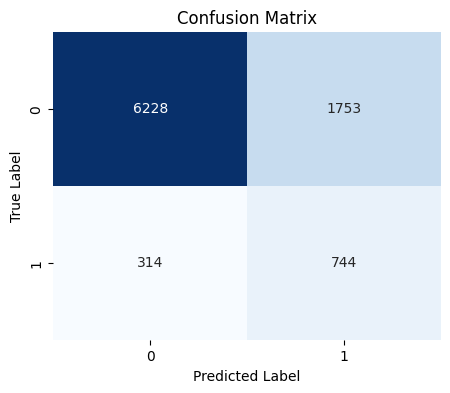

In [ ]:
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_test, digits=4))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


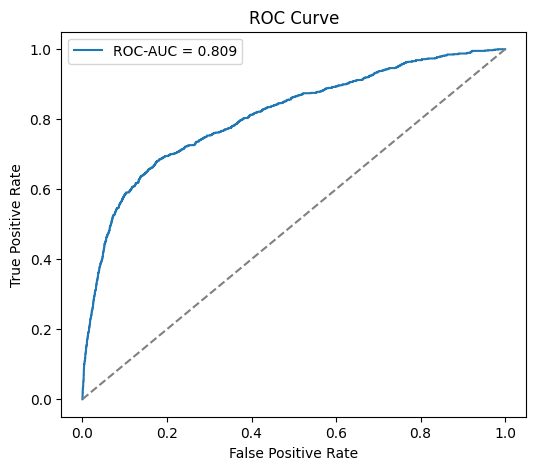

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

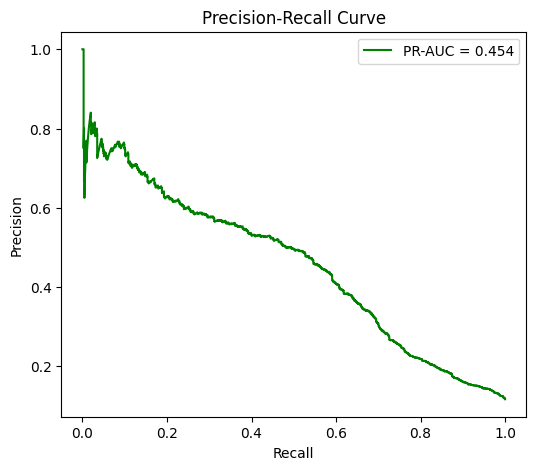

In [ ]:
prec, rec, _ = precision_recall_curve(y_test, y_proba_test)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR-AUC = {pr_auc:.3f}", color="green")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


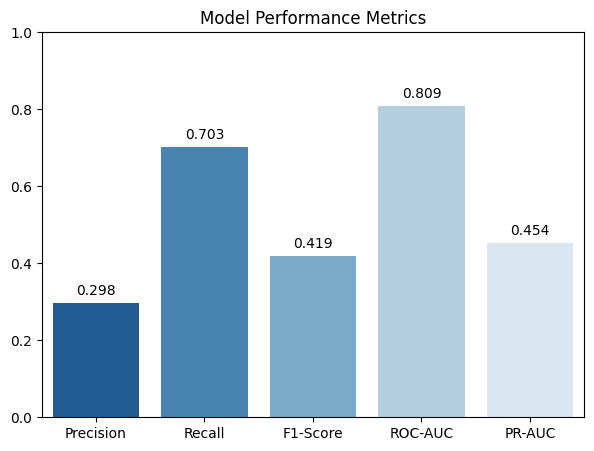

In [ ]:
metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'ROC-AUC': roc_auc,
    'PR-AUC': pr_auc
}

plt.figure(figsize=(7,5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_r")
plt.title("Model Performance Metrics")
plt.ylim(0,1)
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)
plt.show()

### 3.4.2.&nbsp; LightGBM

In [ ]:
pipe_final.set_params(model=LGBMClassifier(**best_params_lgbm, random_state=42))

pipe_final.fit(X_train, y_train)

y_proba_test = pipe_final.predict_proba(X_test)[:,1]
y_pred_test = (y_proba_test >= best_t_lgbm).astype(int)

precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_proba_test)
pr_auc = average_precision_score(y_test, y_proba_test)

print("=== FINAL EVALUATION ===")
print(f"Optimal Threshold: {best_t_lgbm:.2f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

[LightGBM] [Info] Number of positive: 4231, number of negative: 31925
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 36156, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117021 -> initscore=-2.020951
[LightGBM] [Info] Start training from score -2.020951
=== FINAL EVALUATION ===
Optimal Threshold: 0.10
Precision: 0.3045
Recall: 0.7023
F1-score: 0.4248
ROC-AUC: 0.8051
PR-AUC: 0.4490


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

           0     0.9523    0.7874    0.8620      7981
           1     0.3045    0.7023    0.4248      1058

    accuracy                         0.7774      9039
   macro avg     0.6284    0.7448    0.6434      9039
weighted avg     0.8764    0.7774    0.8108      9039



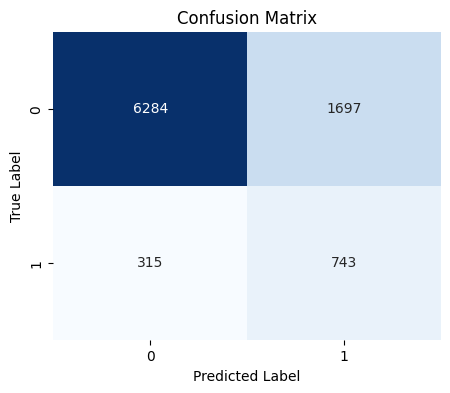

In [ ]:
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred_test, digits=4))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

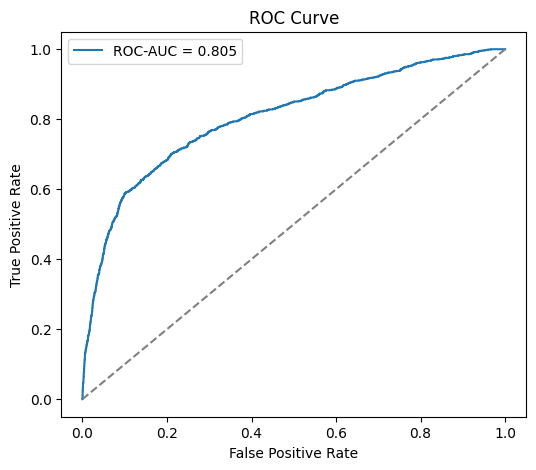

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

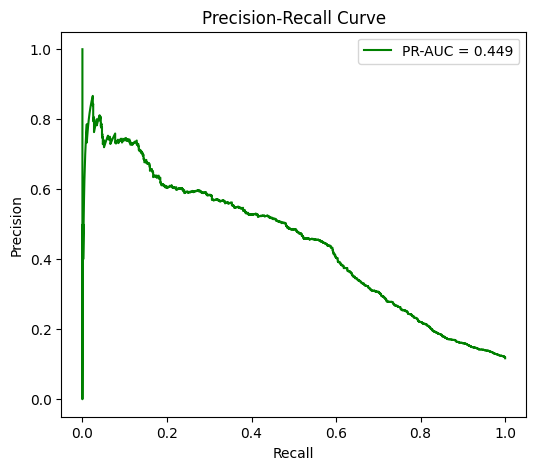

In [ ]:
prec, rec, _ = precision_recall_curve(y_test, y_proba_test)
plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR-AUC = {pr_auc:.3f}", color="green")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

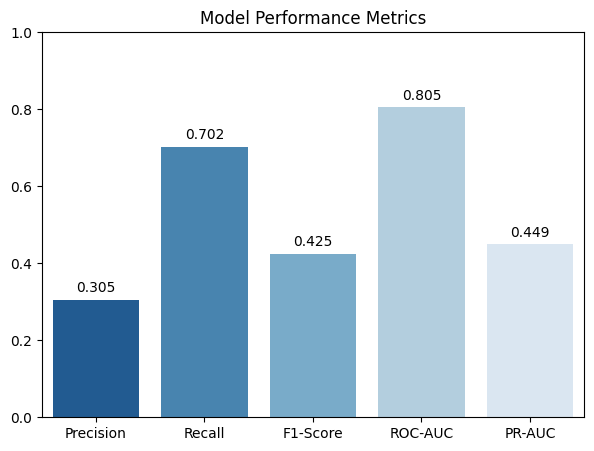

In [ ]:
metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'ROC-AUC': roc_auc,
    'PR-AUC': pr_auc
}

plt.figure(figsize=(7,5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="Blues_r")
plt.title("Model Performance Metrics")
plt.ylim(0,1)
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)
plt.show()

Hasilnya model CATBoost lebih unggul sedikit dalam melakukan prediksi pada dataset ini, dengan nilai evaluasi metrik sebagai berikut:

*   Precision: 29.8%
*   Recall: 70.3%
*   F1-Score: 41.9%
*   ROC-AUC: 80.9%
*   PR-AUC: 45.4%

Model ini dipilih karena metric PR-AUC lebih baik, sehingga model lebih mampu dalam membedakan antar kelasnya.

# 4.&nbsp; Model Interpretation

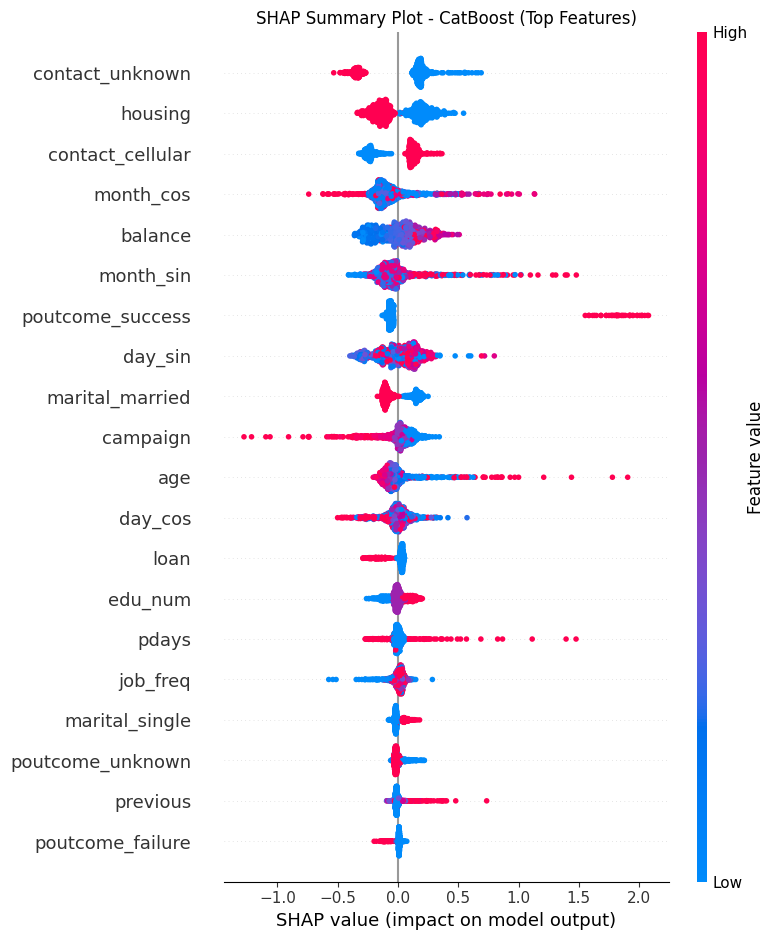

<Figure size 640x480 with 0 Axes>

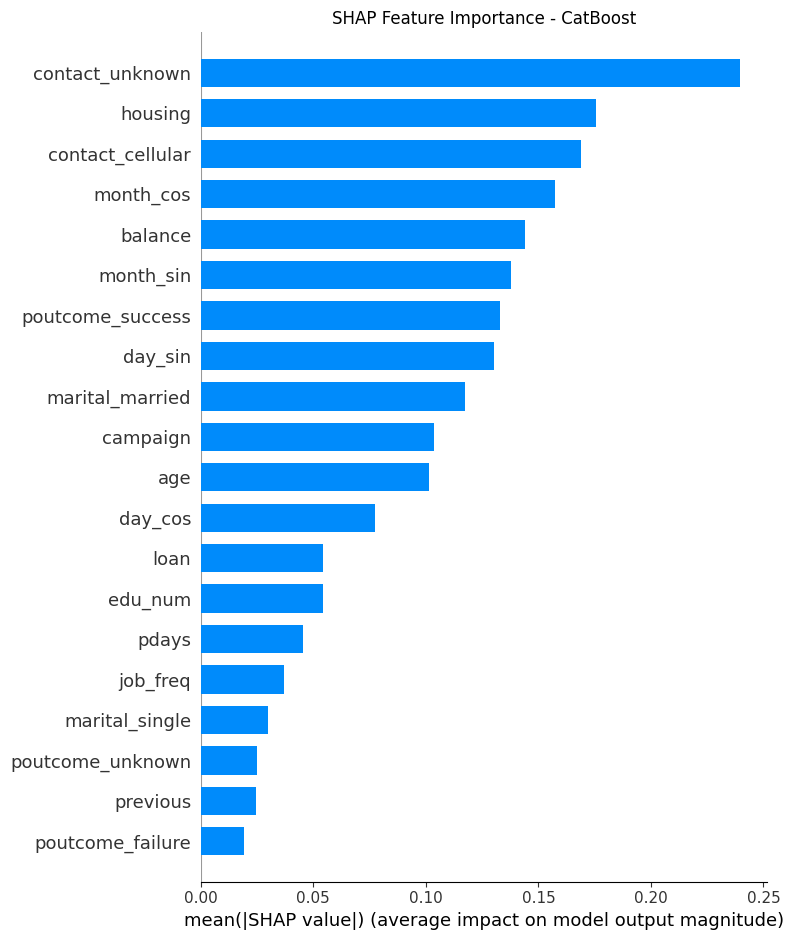

<Figure size 640x480 with 0 Axes>

In [ ]:
best_cat_final = CatBoostClassifier(**best_params_cat, random_state=42, verbose=0)
best_cat_final.fit(X_train, y_train)

X_test_sample = X_test.sample(1000, random_state=42)
explainer = shap.TreeExplainer(best_cat_final)
shap_values = explainer.shap_values(X_test_sample)

plt.title("SHAP Summary Plot - CatBoost (Top Features)")
shap.summary_plot(shap_values, X_test_sample, plot_type="dot", show=True)  # tampil di notebook
plt.tight_layout()
plt.savefig("shap_summary_dot.png", dpi=300, bbox_inches="tight")  # save gambar
plt.show()

plt.title("SHAP Feature Importance - CatBoost")
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=True)  # tampil di notebook
plt.tight_layout()
plt.savefig("shap_summary_bar.png", dpi=300, bbox_inches="tight")
plt.show()

idx = 10
shap.initjs()

force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[idx, :],
    X_test_sample.iloc[idx, :]
)

display(force_plot)

shap.save_html("shap_force_plot.html", force_plot)

The SHAP analysis reveals that the most influential features affecting the model’s prediction are contact type (unknown and cellular), housing loan status, month-related cyclical features, and account balance. These variables significantly drive whether a customer subscribes to the term deposit. In particular, customers with unknown contact information or those contacted via cellphone tend to have stronger predictive influence, highlighting the importance of communication channels in campaign success.

# 5.&nbsp; Saving Model

In [ ]:
pipe_final.set_params(model=CatBoostClassifier(**best_params_cat, random_state=42, verbose=0))

with open("final_catboost_model.pkl", "wb") as f:
    pickle.dump(pipe_final, f)

print("✅ Model has been saved successfully!")

✅ Model has been saved successfully!


# 6.&nbsp; Conclusion



*   The CatBoostClassifier achieved the best overall performance, delivering the highest ROC-AUC and PR-AUC scores, indicating strong predictive capability even with an imbalanced dataset.

*   According to the SHAP analysis, the most influential features were contact, housing, balance, and month, which played a crucial role in determining customer subscription likelihood.

*   Customers with stable financial conditions and those contacted through effective communication channels at the right time were more likely to subscribe.

*   This model provides valuable insights that can help the marketing team optimize targeting strategies and improve campaign efficiency by focusing on the most promising customer segments.





